# **PROJETO ROSSMAN**

<center><img width="30%" src="https://logo-logos.com/wp-content/uploads/2016/11/Rossmann_logo_logotype.png
"></center>

A Rossman opera em mais de 3000 drogarias em 7 países europeus. Atualmente, os gerentes das lojas foram incubidos fazer uma previsão de até 6 semanas das vendas diárias das lojas.

As vendas das lojas são influenciados por algumas variáveis, tais como feriados, competidores, promoções, etc.

Saber com antecedencia as vendas é muito importante para os gestores, pois com base nesses dados, eles podem investir com mais exatidão nas lojas e dias que se vendem mais, tornando o investimento mais eficiente.

Neste projeto iremos então, fazer um modelo de previsão de vendas das próximas 6 semanas para que o time de gestão saiba quanto investir em cada loja.

Os dados foram obtidos no [Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data).

# 0.0 - IMPORTANDO AS BIBLIOTECAS

In [1]:
import datetime
import math
import numpy  as np
import pandas as pd
import random
import pickle
import inflection
import warnings
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from matplotlib            import gridspec as GridSpec
from IPython.display       import Image
from IPython.core.display  import HTML
from tabulate              import tabulate

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 - FUNÇÕES

In [83]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range(1, kfold+1) ):
        if verbose:
            print('\nKFold nunmber: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

        # Filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # Training and validation Dataset

        # Training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) )

        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE CV': np.round( np.mean(mae_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(mae_list), 2 ).astype(str),
                           'MAPE CV': np.round( np.mean(mape_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(mape_list), 2 ).astype(str),
                           'RMSE': np.round( np.mean(rmse_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(rmse_list), 2 ).astype(str) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 - CARREGANDO DADOS

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Vamos fazer um merge desses dois dados
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 - DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1 - Renomeando as colunas

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

## 1.2 - Dimensões dos dados

In [6]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


## 1.3 - Tipos de dados

In [7]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

Podemos observar que a coluna *date* está como *object*, por isso vamos transformar no formato suportado pelo pandas:

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Conferindo dados faltantes

In [9]:
df1.isnull().sum().sort_values(ascending=True)

store                                0
promo2                               0
assortment                           0
store_type                           0
state_holiday                        0
promo                                0
school_holiday                       0
customers                            0
sales                                0
date                                 0
day_of_week                          0
open                                 0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2_since_year               508031
promo2_since_week               508031
promo_interval                  508031
dtype: int64

## 1.5 - Preenchendo dados faltantes

###  *competition_distance*:
Verifiquei a distancia máxima que se tem registro do competidor, e para preencher os dados faltantes, segui a hipótese de que não há nenhum por perto, e para isso preenchi esse valor com um número bem alto.

In [10]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x )

### *competition_open_since_month* e *competition_open_since_year*

Presumi que existem dois motivos para ter esses dados faltantes:
* não há competidor
* não se tem registro da informação, ou pelo competidor estar há mais tempo que a rossman, ou por esquecimento de registro

Para tratar esses dados vou colocar a data da venda no lugar dos dados faltantes, pois julgo que essa informação é relevante

In [11]:
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

### *promo2_since_year* e *promo2_since_week*:

Os dados faltantes são porque a loja resolveu não extender a promoção. irei tratar esses dados faltantes como no caso anterior
 

In [12]:
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

### promo_interval:
Mostra o intervalo em que acontece o promo2, está em uma lista. Para tratar os dados faltantes, vou fazer uma nova coluna e colocar 0 para quando não tiver promoção e 1 para quando tiver.

In [13]:
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

Vamos conferir se as transformações deram certo:

In [14]:
df1.sample(5).T

,911004,32684,707958,368552,693042
store,835,350,719,401,298
day_of_week,6,4,6,2,5
date,2013-04-06 00:00:00,2015-07-02 00:00:00,2013-10-05 00:00:00,2014-08-12 00:00:00,2013-10-18 00:00:00
sales,3891,6588,6017,6548,7319
customers,591,469,572,646,619
open,1,1,1,1,1
promo,0,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,a,d,c,a,d


In [15]:
df1.isnull().sum().sort_values(ascending=True)

store                           0
promo_interval                  0
promo2_since_year               0
promo2_since_week               0
promo2                          0
competition_open_since_year     0
competition_open_since_month    0
competition_distance            0
assortment                      0
store_type                      0
school_holiday                  0
state_holiday                   0
promo                           0
open                            0
customers                       0
sales                           0
date                            0
day_of_week                     0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 - Verificar os tipos de dados

Algumas vezes, após tratar os dados, pode ocorrer de mudar o tipo de dado, vamos verificar se houve mudança e se sim, transforma-la de volta.

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

Pela análise, podemos ver que as variáveis: *competition_open_since_month*, *competition_open_since_year*, *promo2_since_week*, *promo2_since_year* estão como tipo *float*, vamos mudar elas para o tipo inteiro, pois meses e anos são valores inteiros.

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 - Estatística Descritiva

Vamos separar as variáveis numérica das categóricas:

In [18]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 - Atributos Numéricos

**Tendência Central -** Média, Mediana

In [19]:
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

**Dispersão-** std, min, max, range, skew, kurtosis

In [20]:
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

Vamos concatenar essas informações verificar como ficou:

In [21]:
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 - Atributo Categórico

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Vamos fazer uma filtragem, pata que state_holiday = 0 e vendas < 0 não entrem no grafico.

In [23]:
aux1 = df1[ ( df1['state_holiday'] != '0') & ( df1['sales'] > 0 ) ]

Vamos fazer boxplots agora, pois são uma das melhores formas de analisar variaveis categóricas 

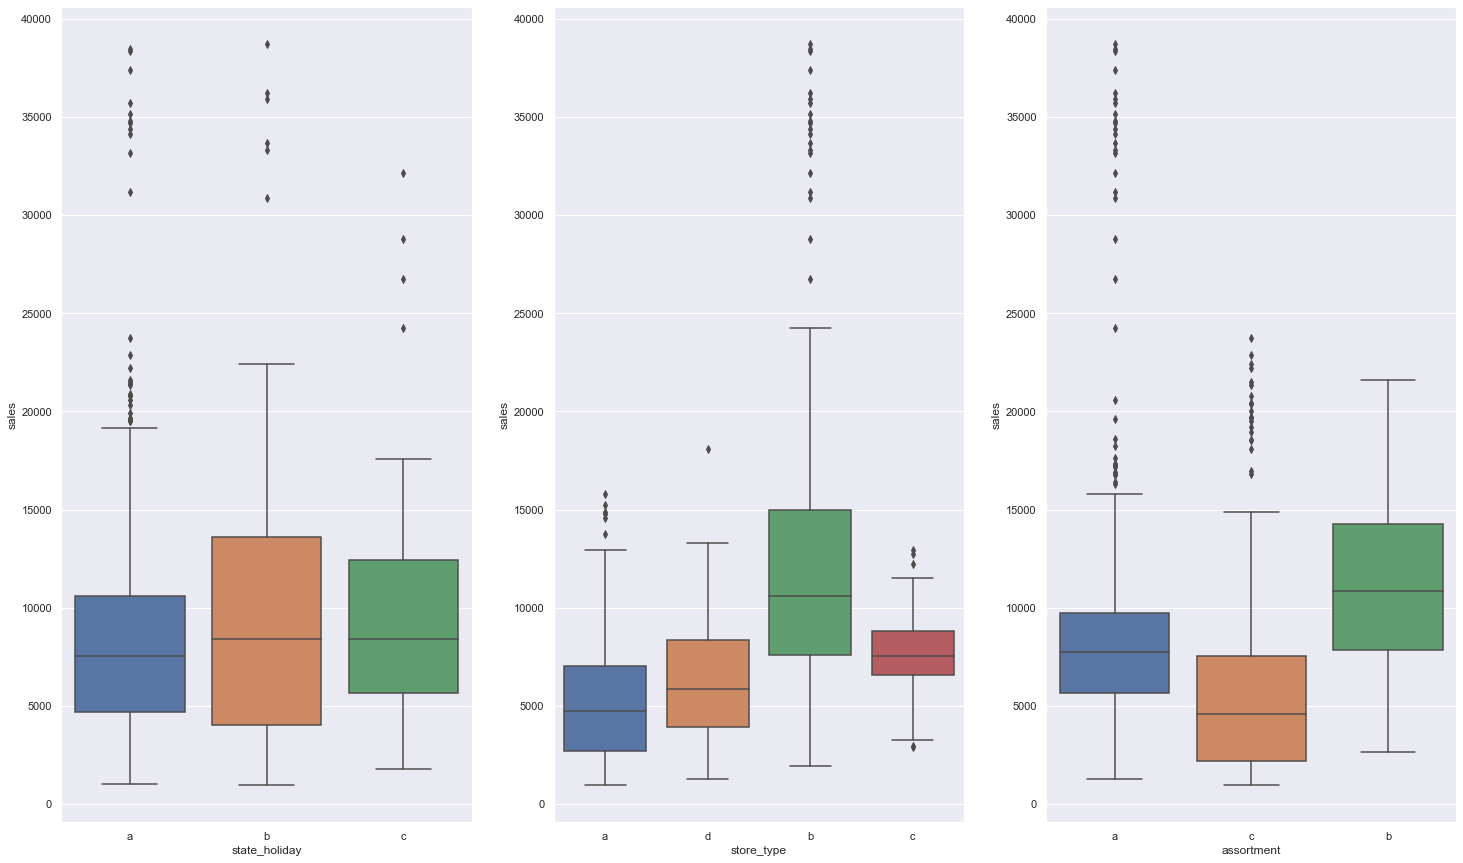

In [24]:
plt.figure(figsize=(25,15))

plt.subplot( 1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1);

# 2.0 - FEATURE ENGINEERING

<center><img width="40%" src="https://image.freepik.com/vetores-gratis/ilustracao-do-conceito-de-processamento_114360-1395.jpg
"></center>

Agora vamos criar hipóteses para podermos trabalhar melhor na análise de dados mais a frente. Caso necessite de derivarmos variáveis para podermos fazer uma análise melhor, agora é a hora de fazermos isso.

In [25]:
df2 = df1.copy()

## 2.1 - Mapa pental de hipóteses


Criei um mapa mental de hipóteses, para poder visualizar melhor o negócio em si, e o que impactaria nas vendas, e a partir disso criei uma lista de hipóteses:

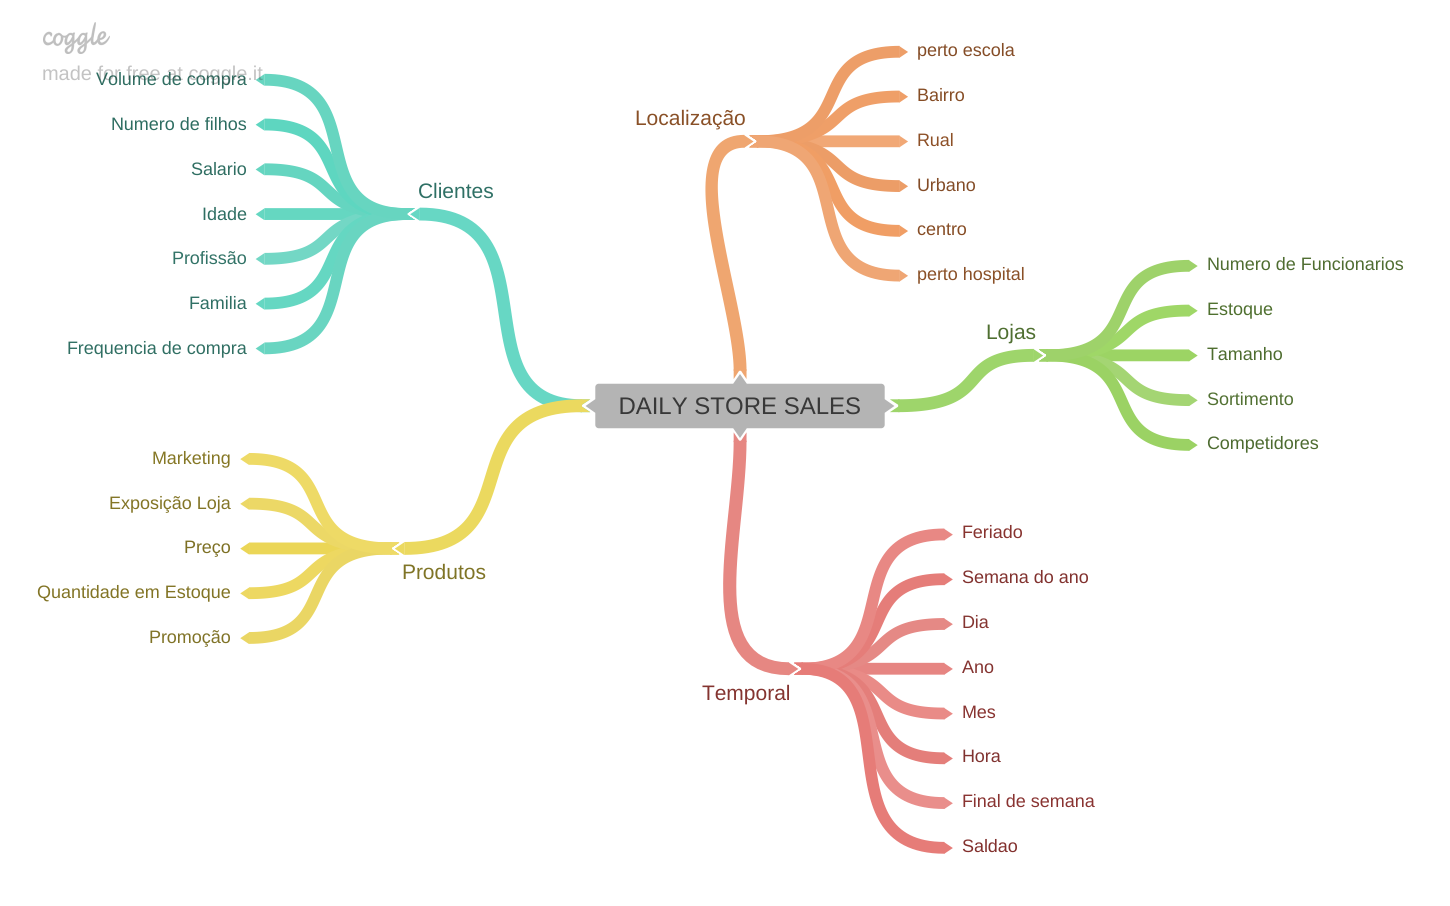

In [26]:
Image( 'DAILY_STORE_SALES.png' )

## 2.2 -  Criação das Hipóteses

### 2.2.1 -  Hipótese Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 - Hipótese Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 - Hipótese Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 - Lista Final de Hipótese


1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

## 2.4 - Feature Engineering

In [27]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W ' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] =  df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 - FILTRAGEM DE VARIÁVEIS

<center><img width="40%" src="https://image.freepik.com/vetores-gratis/cientista-e-especialista-em-dados-extraem-conhecimento-e-percepcoes-dos-dados-analise-de-ciencia-de-dados-controle-de-aprendizado-de-maquina-conceito-de-analise-de-big-data-ilustracao-de-vetor-isolado-de-coral-rosa_335657-2286.jpg
"></center>

Agora iremos filtrar as variáveis nas linhas e colunas, para eliminar os dados com restrições de acordo com o negócio.

In [29]:
df3 = df2.copy()

## 3.1 - Filtragem de linhas

Vamos eliminar as linhas em que a variável *open* seja 0, pois não há necessidade de tirar dados de uma loja fechada. E também vamos eliminar linhas que possam ter a variável *sales* menos que 0.

In [30]:
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2 - Filtragem de colunas

Agora iremos eliminar as colunas desnecessários para nossa análise, seja por ser variáveis derivados, ou irrelevantes para o modelo de predição.

In [31]:
cols_drop = [ 'customers', 'open', 'month_map', 'promo_interval' ]
df3 = df3.drop(cols_drop, axis=1)

Verificando se a filtragem deu certo:

In [32]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0 - EDA - ANÁLISE EXPLORATORIA DE DADOS

<center><img width="40%" src="https://image.freepik.com/vetores-gratis/ilustracao-do-conceito-de-estatisticas-do-site_114360-1434.jpg
"></center>

A análise exploratória de dados serve para medir o impacto das variáveis nas variáveis respotas e também para tentar quantificar a força desse impacto.
Ela possui basicamente 3 objetivos:
* Ganhar experiencia de negócio, pois ao explorar os dados, o cientista cria uma noção mais abrangente do negócio;
* Criar *Insights*, e validar hipóteses levantadas nas etapas prévias;
* Perceber variáveis que são importantes para o modelo.

A EDA está dividida basicamente em 3 análises:
* **Análise univariada:** onde se analisa o comportamento de cada variável;
* **Análise bivariada:** onde se analise como uma variável impacta na resposta;
* **Análise multivariada:** onde se analisam como as variáveis se relacionam entre elas.

In [33]:
df4 = df3.copy()

## 4.1 - Análise univariada

### 4.1.1 - Variável resposta

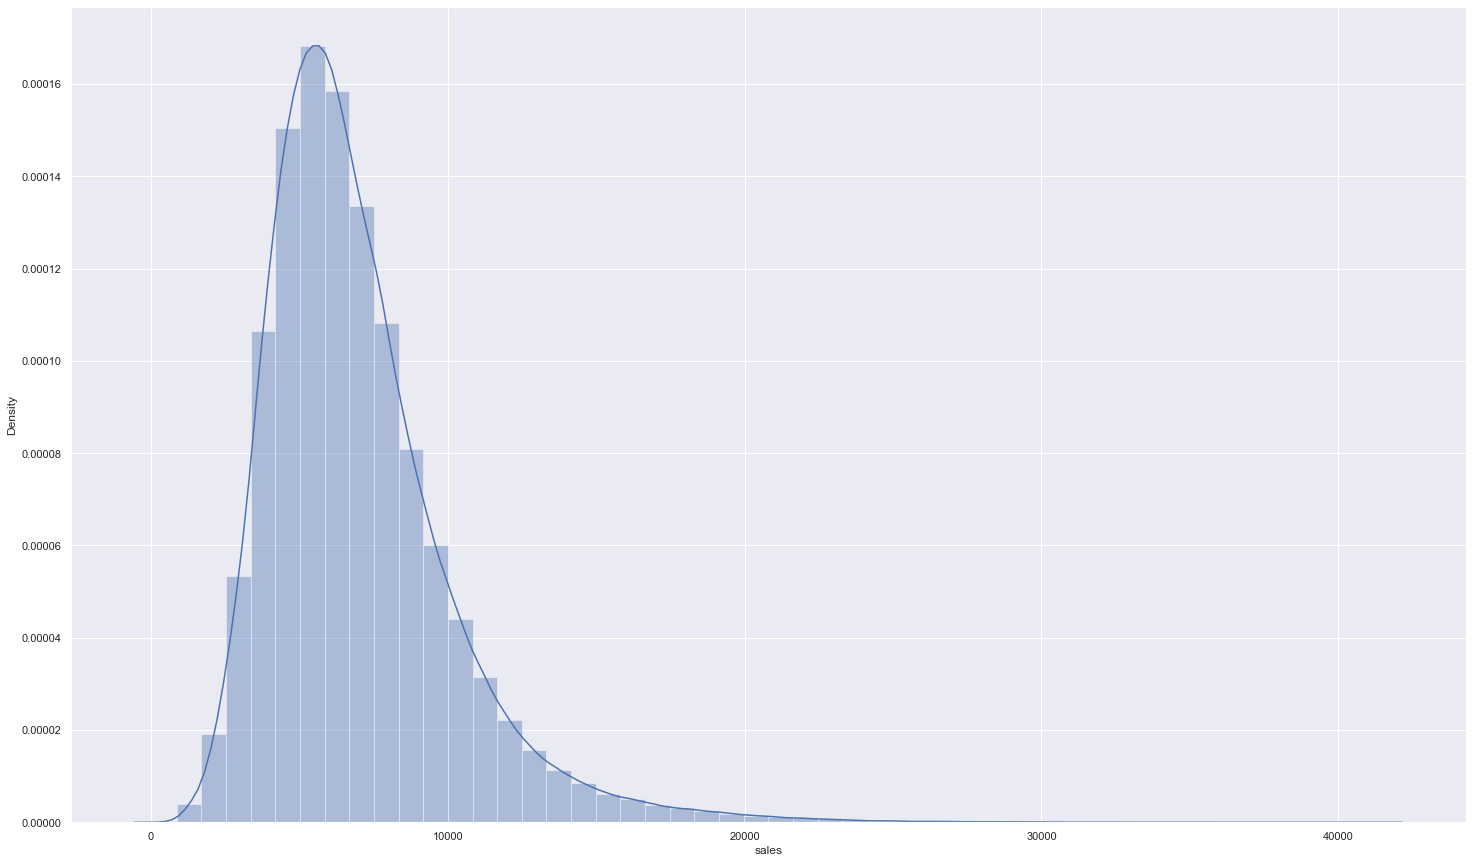

In [34]:
plt.figure(figsize=(25,15))
sns.distplot(df4['sales']);

### 4.1.2 - Variáveis numéricas

<Figure size 1800x1080 with 0 Axes>

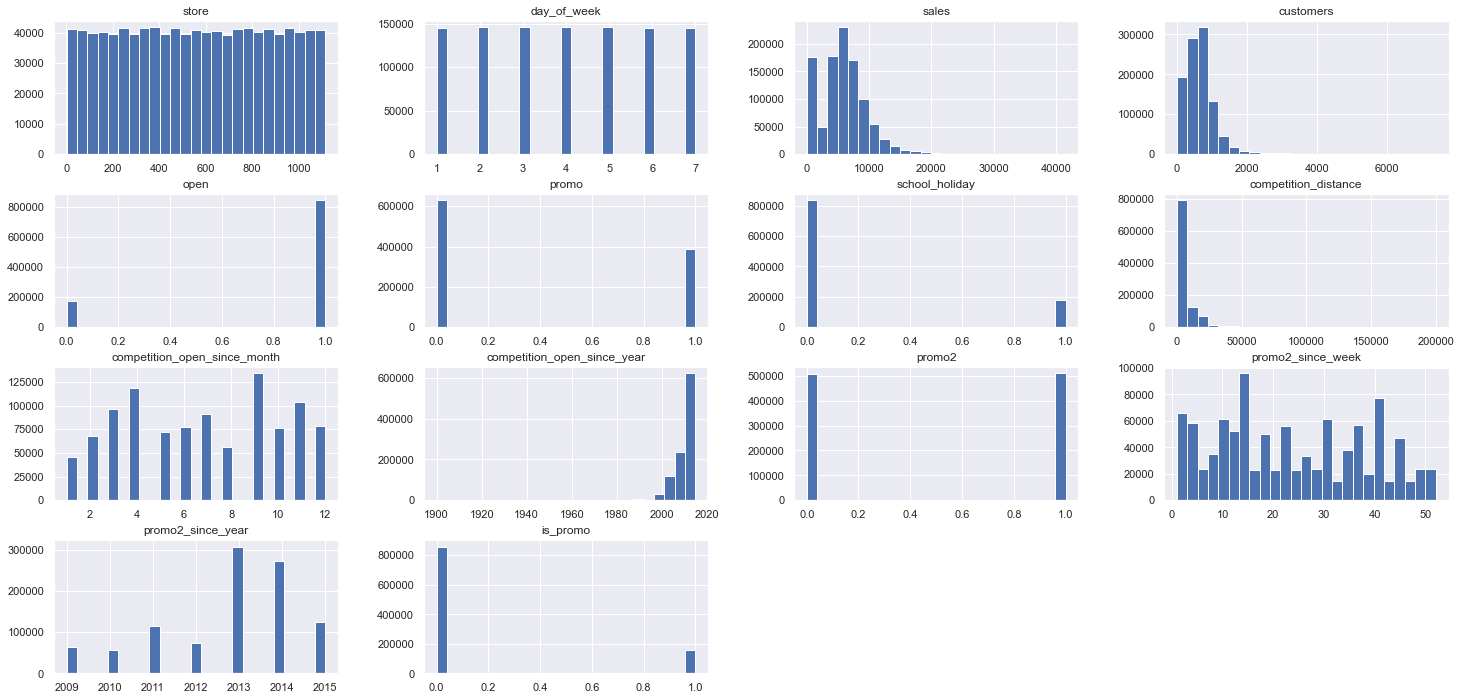

In [35]:
plt.figure(figsize=(25,15))
num_attributes.hist( bins=25 );

Através desses gráficos podemos deduzi algumas coisas:
* Existem mais lojas sem promoção do que com promoção;
* A concorrencia está mais concentrada e perto das lojas rossman;
* A maior parte das lojas concorrentes abriu suas lojas recentemente

### 4.1.3 - Variáveis categóricas

O dataset possui 3 variáveis categóricas, sendo elas *state_holiday*, *store_type* e *assortment*

In [36]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

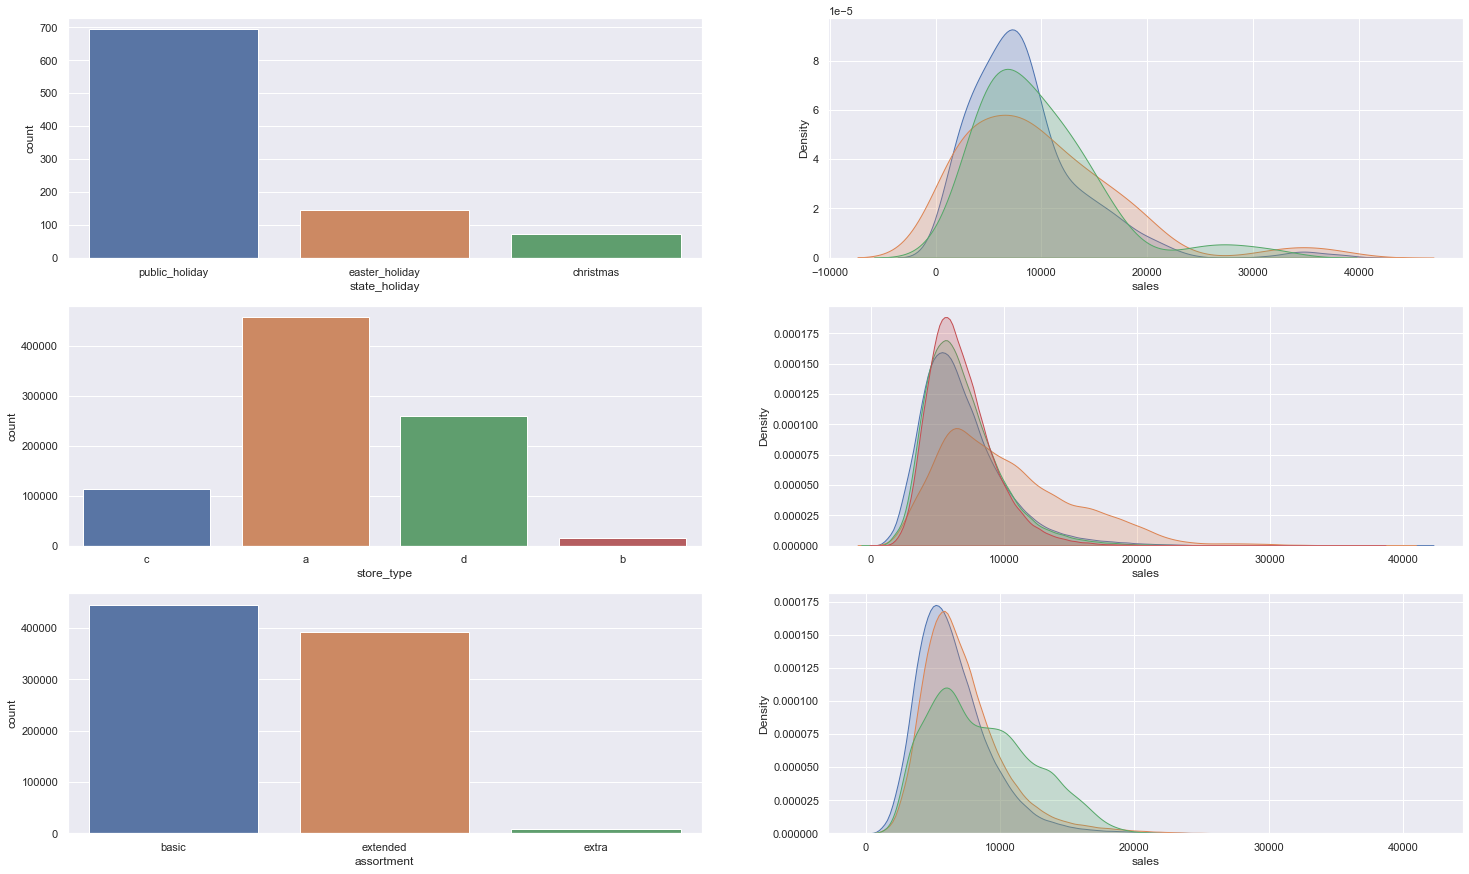

In [37]:
plt.figure(figsize=(25,15))

# state_holiday
plt.subplot( 3, 2, 1)
a = df4[ df4['state_holiday'] != 'regular_day' ]
sns.countplot( a['state_holiday'] );

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday' ]['sales'], label = 'public_holiday', shade=True );
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday' ]['sales'], label = 'easter_holiday', shade=True );
sns.kdeplot( df4[ df4['state_holiday'] == 'christmas' ]['sales'], label = 'christmas', shade=True );

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] );

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label='a', shade=True );
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label='b', shade=True );
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label='c', shade=True );
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label='d', shade=True );

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] );

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[ df4['assortment'] == 'basic' ]['sales'], label='basic', shade=True );
sns.kdeplot( df4[ df4['assortment'] == 'extended' ]['sales'], label='extended', shade=True );
sns.kdeplot( df4[ df4['assortment'] == 'extra' ]['sales'], label='extra', shade=True );

Por esses gráficos podemos notar que:
* Apesar de ter menos feriados de natal, o volume de vendas nesse feriado é grande;
* O tipo de loja b, apesar de ser minoria, ela movimenta muitas vendas.

## 4.2 - Análise bivariada

Vamos agora começar a validar algumas das hipóteses levantadas anteriormente

### H1 - Lojas com maior sortimentos deveriam vender mais. (**F**)

A hipótese é **FALSA**, pois como demonstrei por dados, as lojas com mais sortimentos vendem **MENOS**.

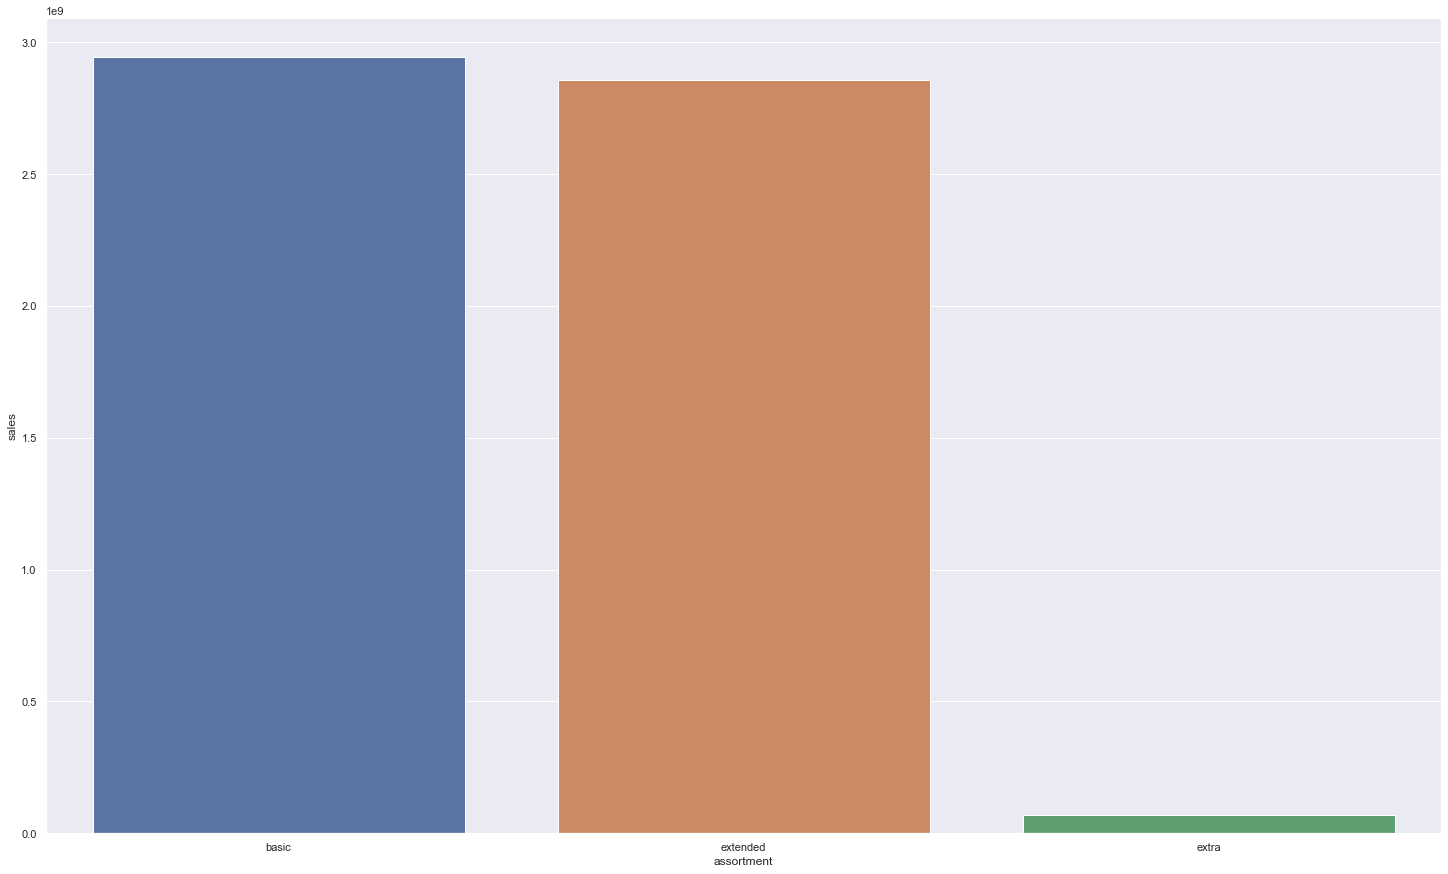

In [38]:
plt.figure(figsize=(25,15))
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

O assortment extra vendeu muito menos que os outros tipos, mas será que sempre foi assim? vou analisar a venda por período para verificar isso.

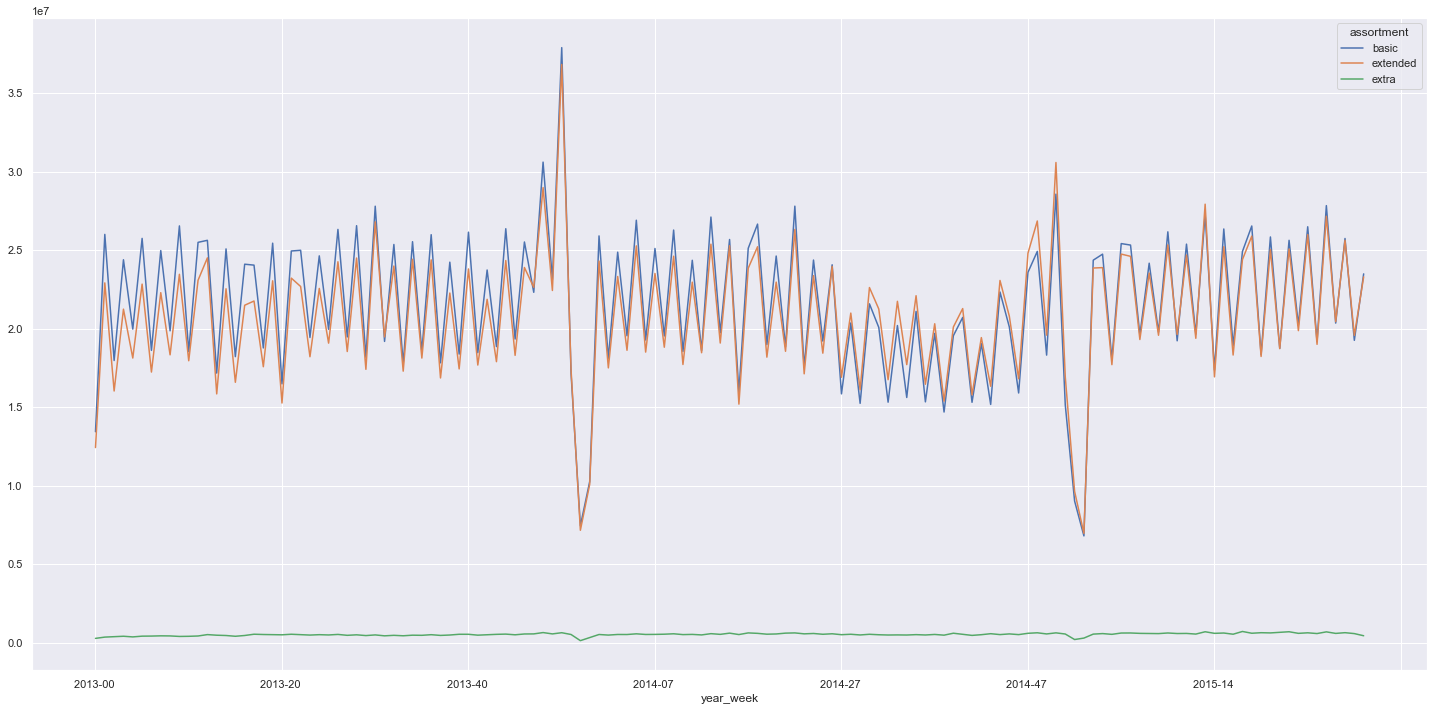

In [39]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

Como o volume de vendas é bem menor que os outros tipos, a linha parece linear, mas vou analisar ela especificamente:

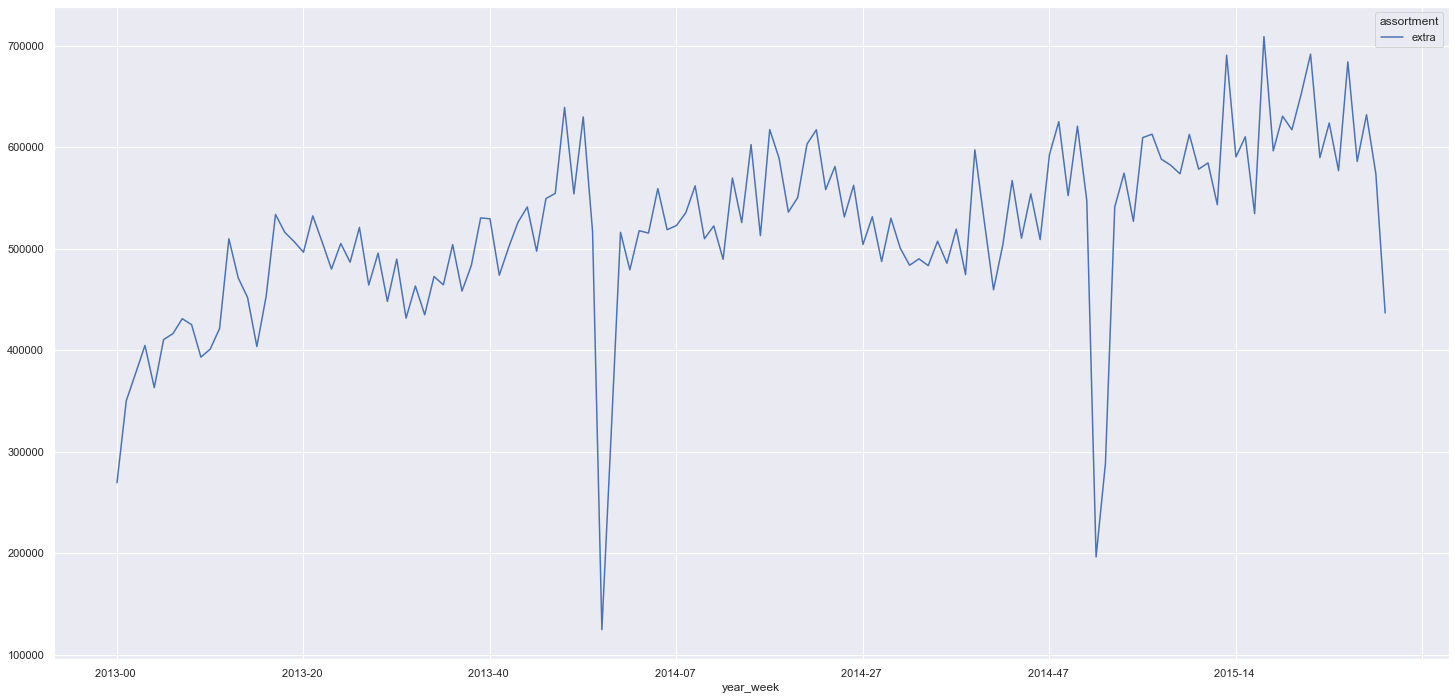

In [40]:
aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

Como pudemos observar, ela não é linear.

### H2 - Lojas com competidores mais próximos deveriam vender menos. (**F**)

A hipótese é ***FALSA*** pois como foi comprovado, quanto mais próximo estão os competidores, **MAIORES** são as vendas.

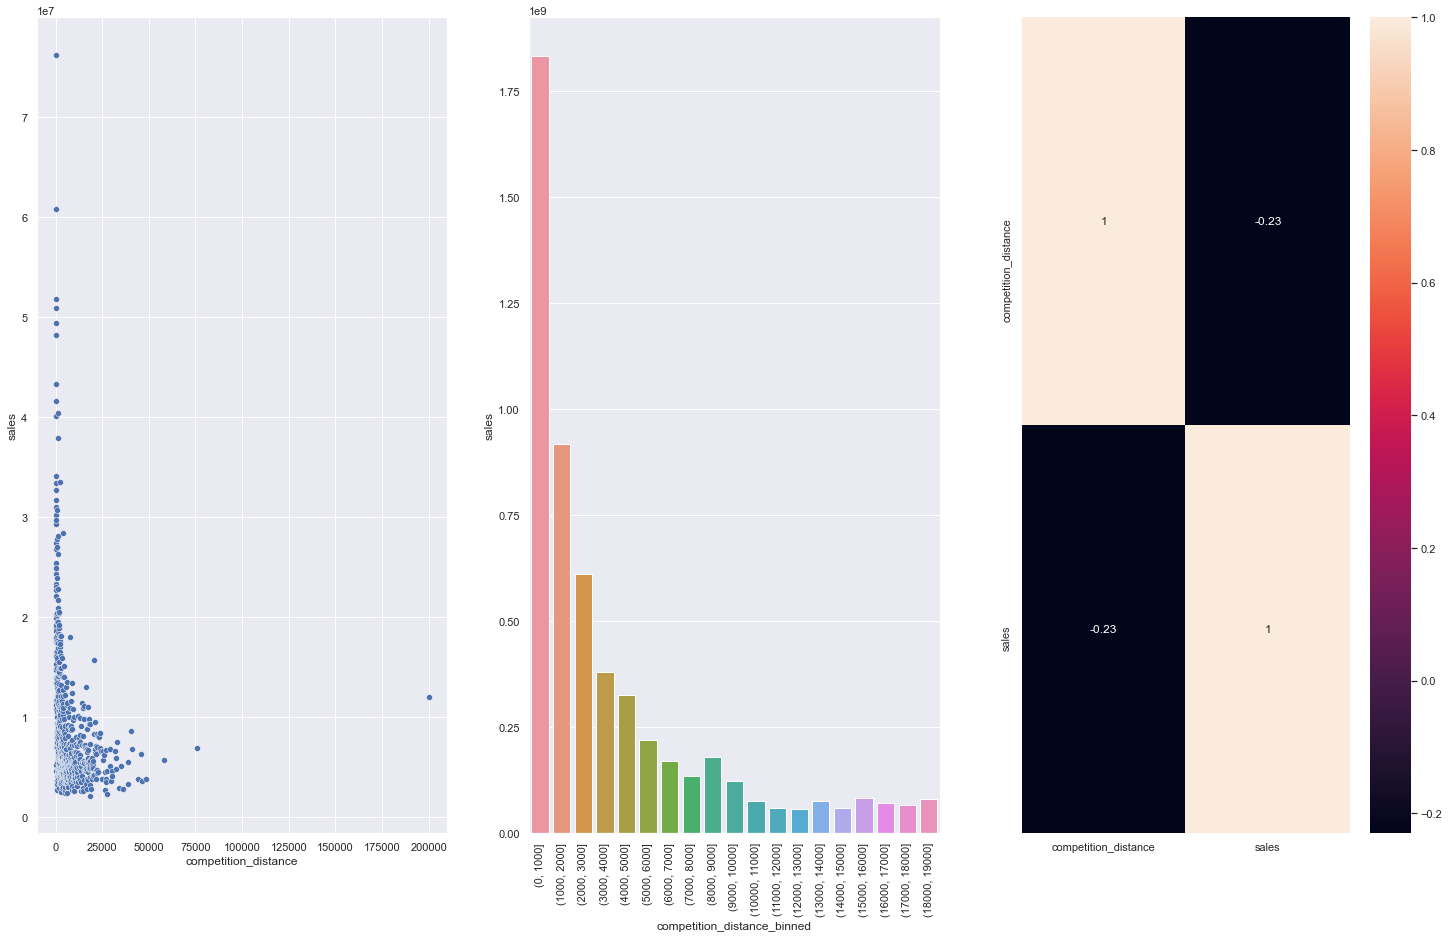

In [41]:
plt.figure(figsize=(25,15))
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True );

### H3 -  Lojas com competidores à mais tempo deveriam vendem mais. (**F**)

Curiosamente, as vendas crescem quando os competidores são recentes.
Portanto essa hipótese é **FALSA**.

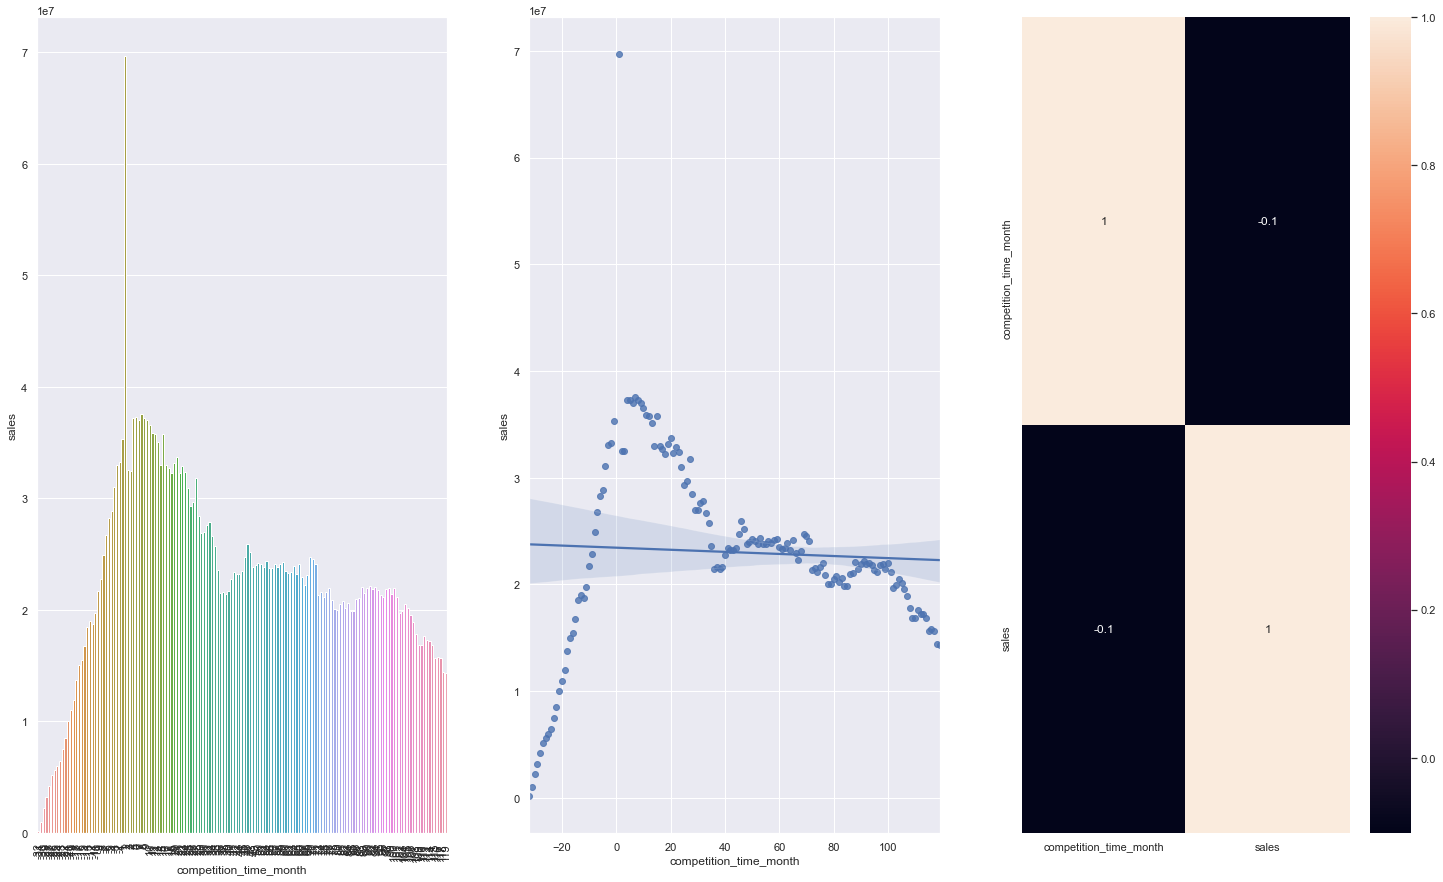

In [42]:
plt.figure(figsize=(25,15))
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[ ( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4  - Lojas com promoções ativas por mais tempo deveriam vender mais. (**F**)

A afirmação é **FALSA** pois quanto mais tempo em promoção, a tendencia é de queda nas vendas. Muito provavelmente porque o consumidor passará a perceber que o item não é mais promoção e está em seu preço regular.

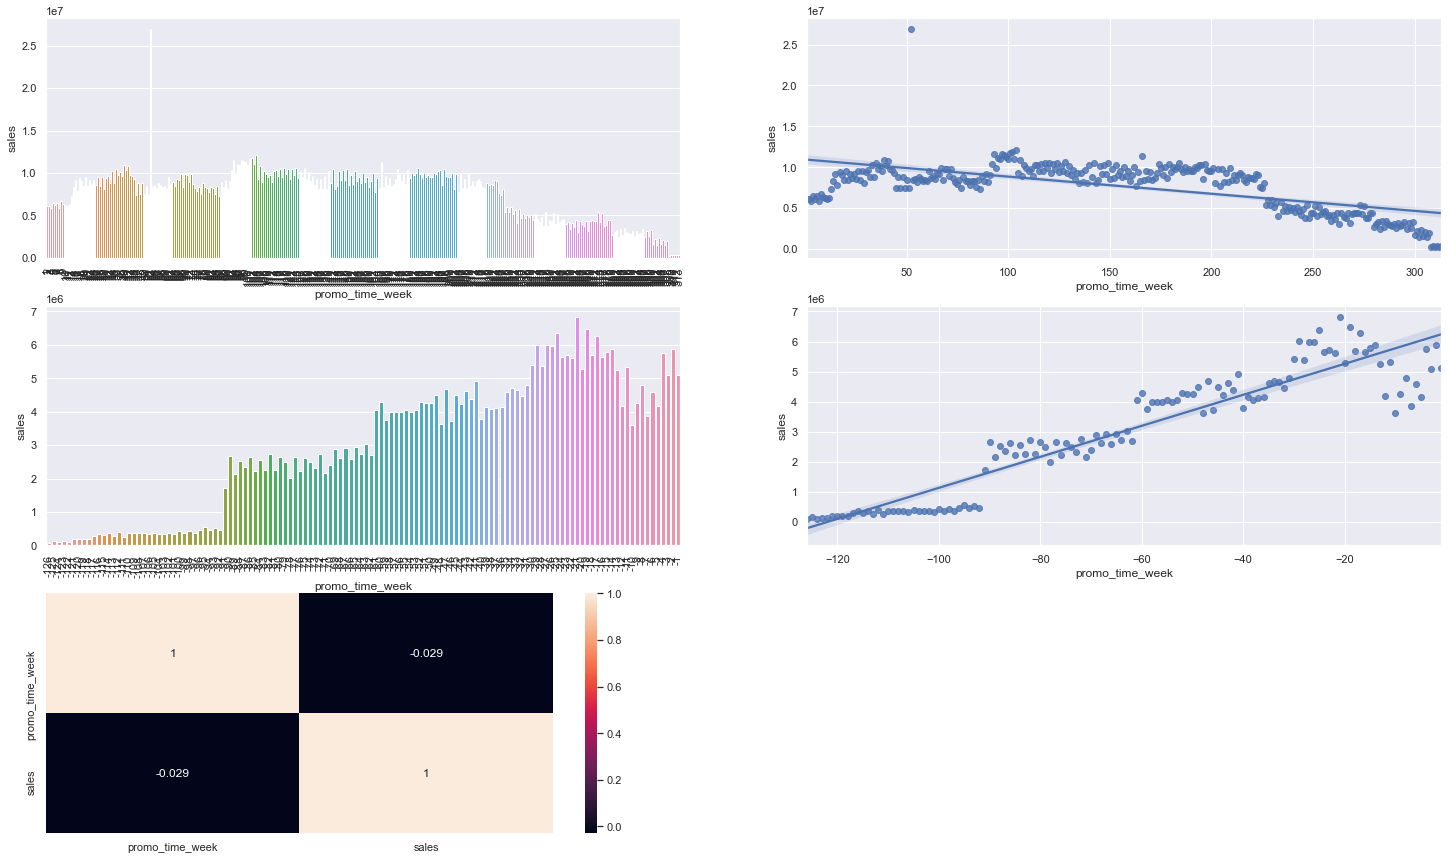

In [43]:
plt.figure(figsize=(25,15))
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

# Promoção Extendida
plt.subplot( 3, 2, 1 )
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 3, 2, 2 )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

# Promoção Regular
plt.subplot( 3, 2, 3 )
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( 3, 2, 4 )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( 3, 2, 5)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

Vale notar que nesse caso, os valores negativos de *promo_time_week* é o período antes da promoção extendida acontecer, e os valores positivos são o período da promoção extendida.

### <s>H5 - Lojas com mais dias de promoção deveriam vender mais.<s>

### H6 - Lojas com mais promoções consecutivas deveriam vender mais. (**F**)

Apesar do comportamento ser parecido, lojas com promoções consecutivas tendem a vender **MENOS**, portanto a afirmação é **FALSA**.

In [44]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


<Figure size 1800x1080 with 0 Axes>

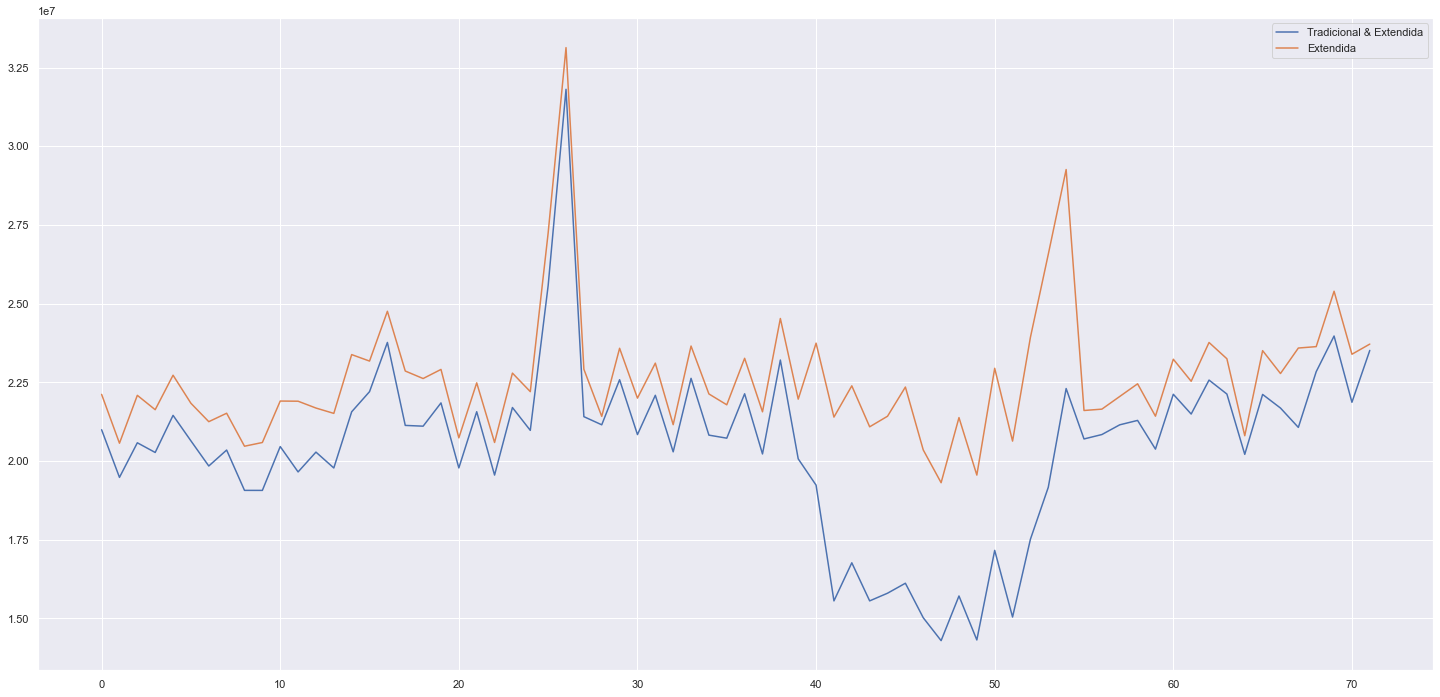

In [45]:
plt.figure(figsize=(25,15))
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H7 - Lojas abertas durante o feriado de Natal deveriam vender mais. (**F**)

Como Constatado no gráfico, as vendas de natal não são altos se comparados à outros feriados, portanto a hipótese levantada é **FALSA**.

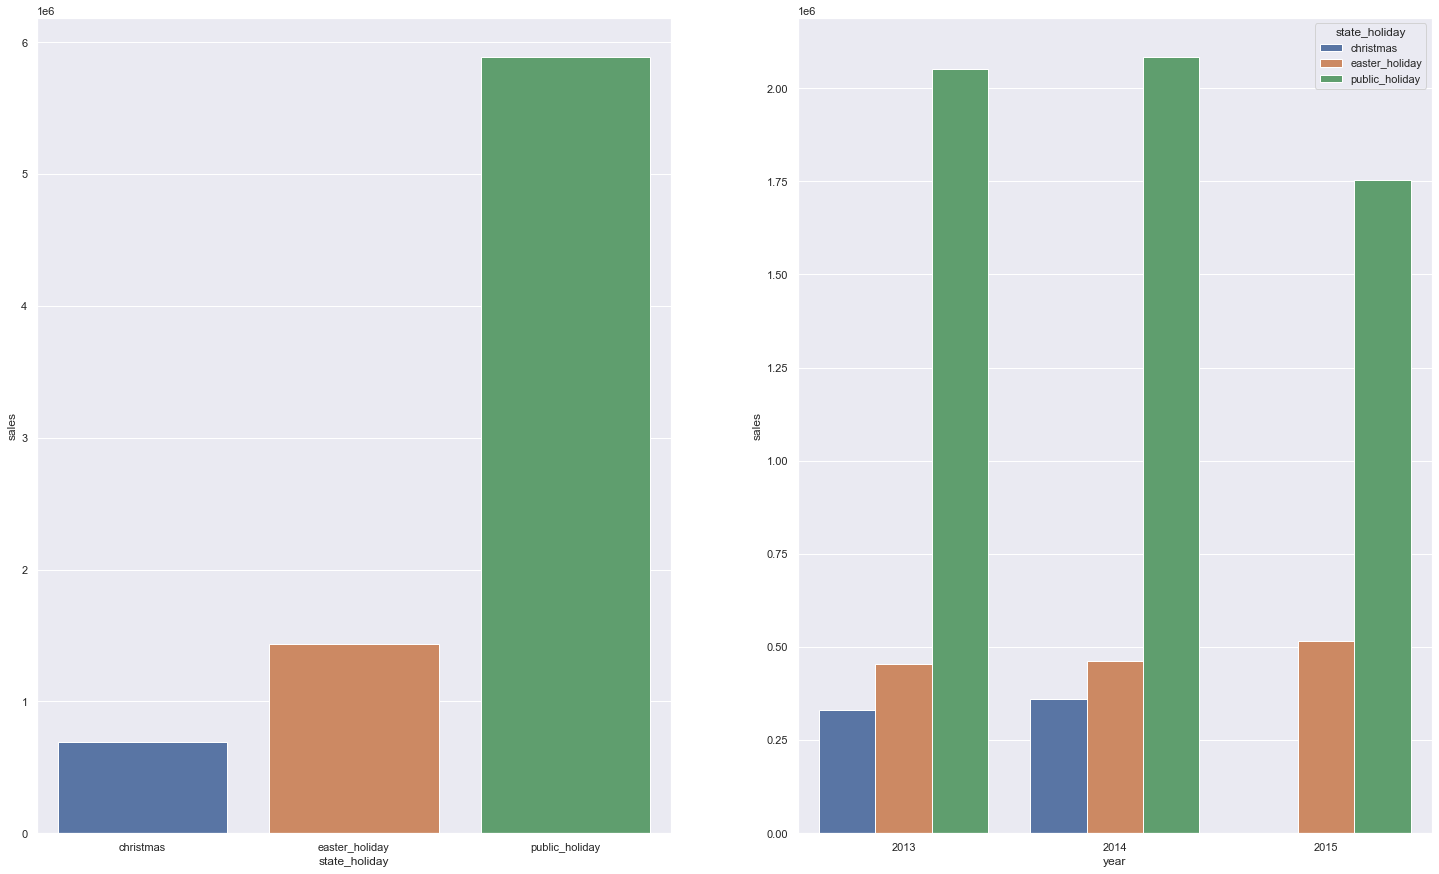

In [46]:
plt.figure(figsize=(25,15))
aux = df4[ df4['state_holiday'] != 'regular_day' ]

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['state_holiday', 'year']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);

### H8 - Lojas deveriam vender mais ao longo dos anos. (**F**)

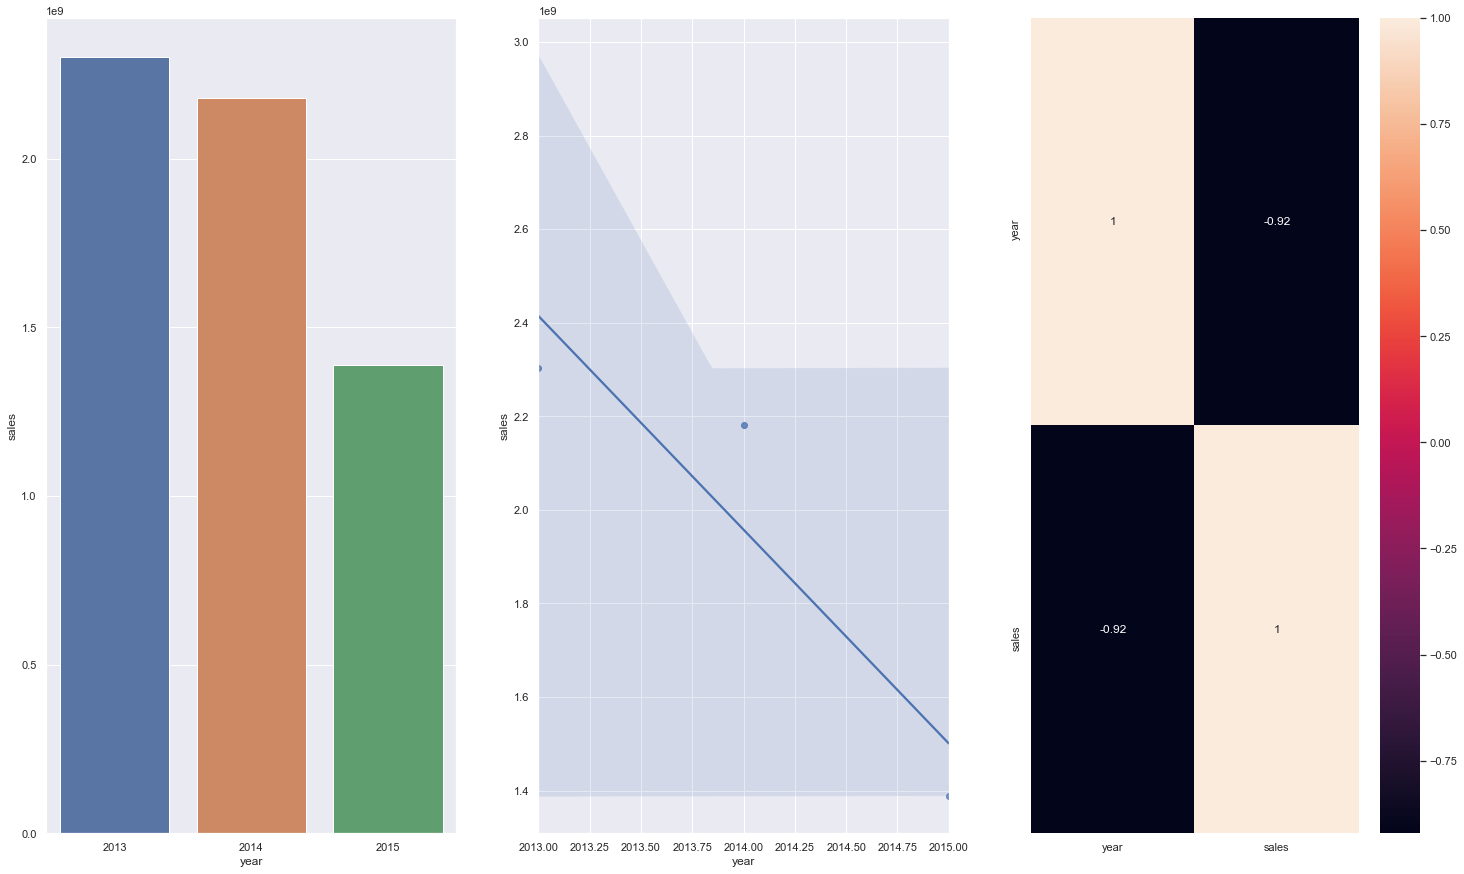

In [47]:
plt.figure(figsize=(25,15))

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True);

Pelos dados, as lojas vendem **MENOS** ao longo dos anos, vendo uma tendencia de queda. Portando a hipótese levantada é **FALSA**.

### H9 - Lojas deveriam vender mais no segundo semestre do ano. (**F**)

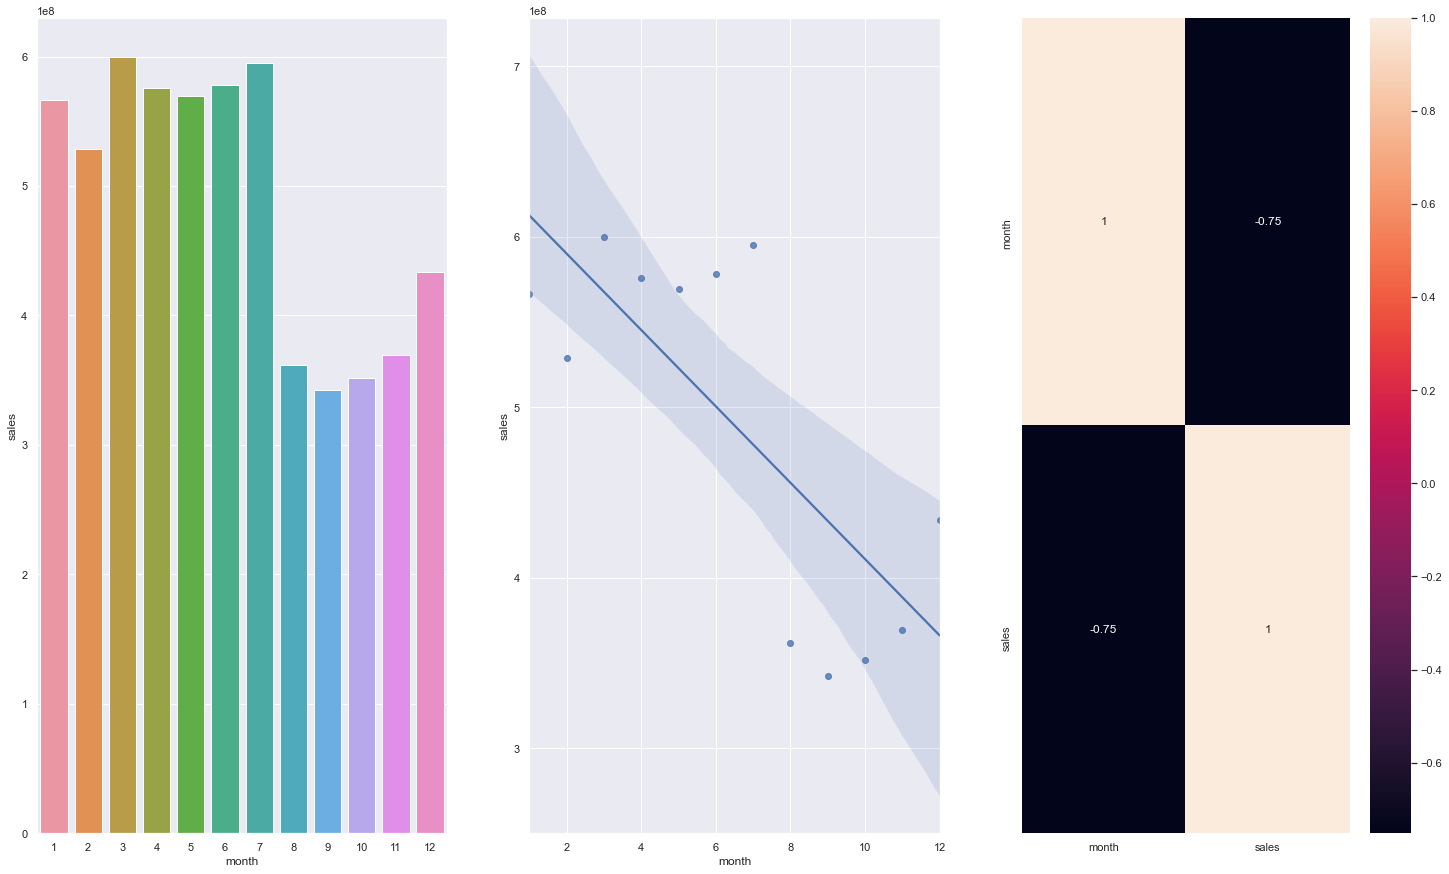

In [48]:
plt.figure(figsize=(25,15))

aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

Como apontado em gráfico, a tendencia é de queda no segundo semestre, e não de aumento nas vendas.

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês.(**V**)

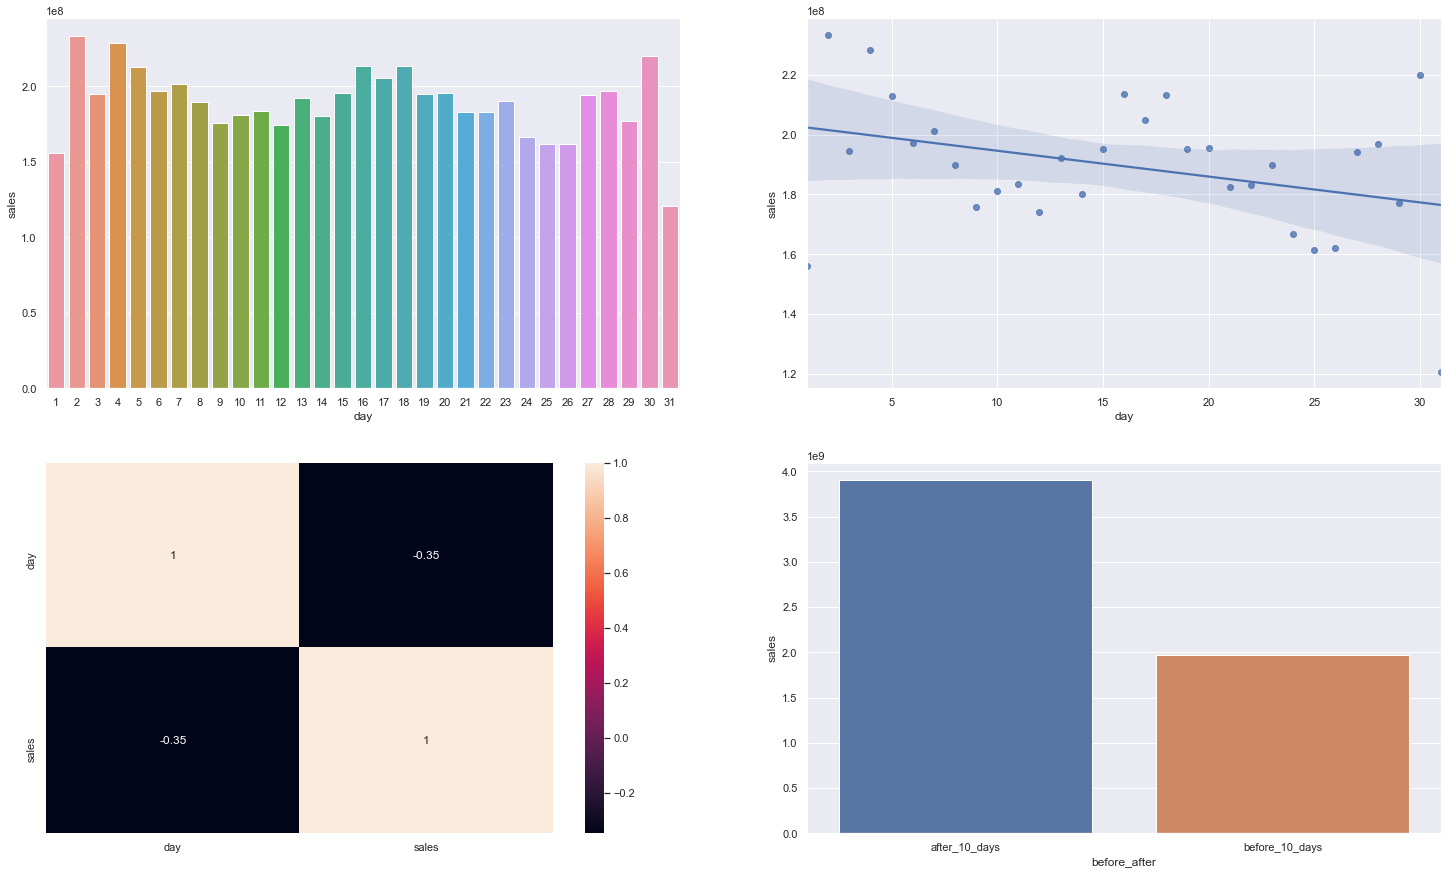

In [49]:
plt.figure(figsize=(25,15))

aux1 = df4[ [ 'day', 'sales' ] ].groupby('day').sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

Os primeiros gráficos são inconclusivos, mas depois ao separar as vendas em antes do dia 10 e depois do dia 10, deu para se verificar que as vendas depois do dia 10 são maiores.

### H11 - Lojas deveriam vender menos aos finais de semana. (**V**)

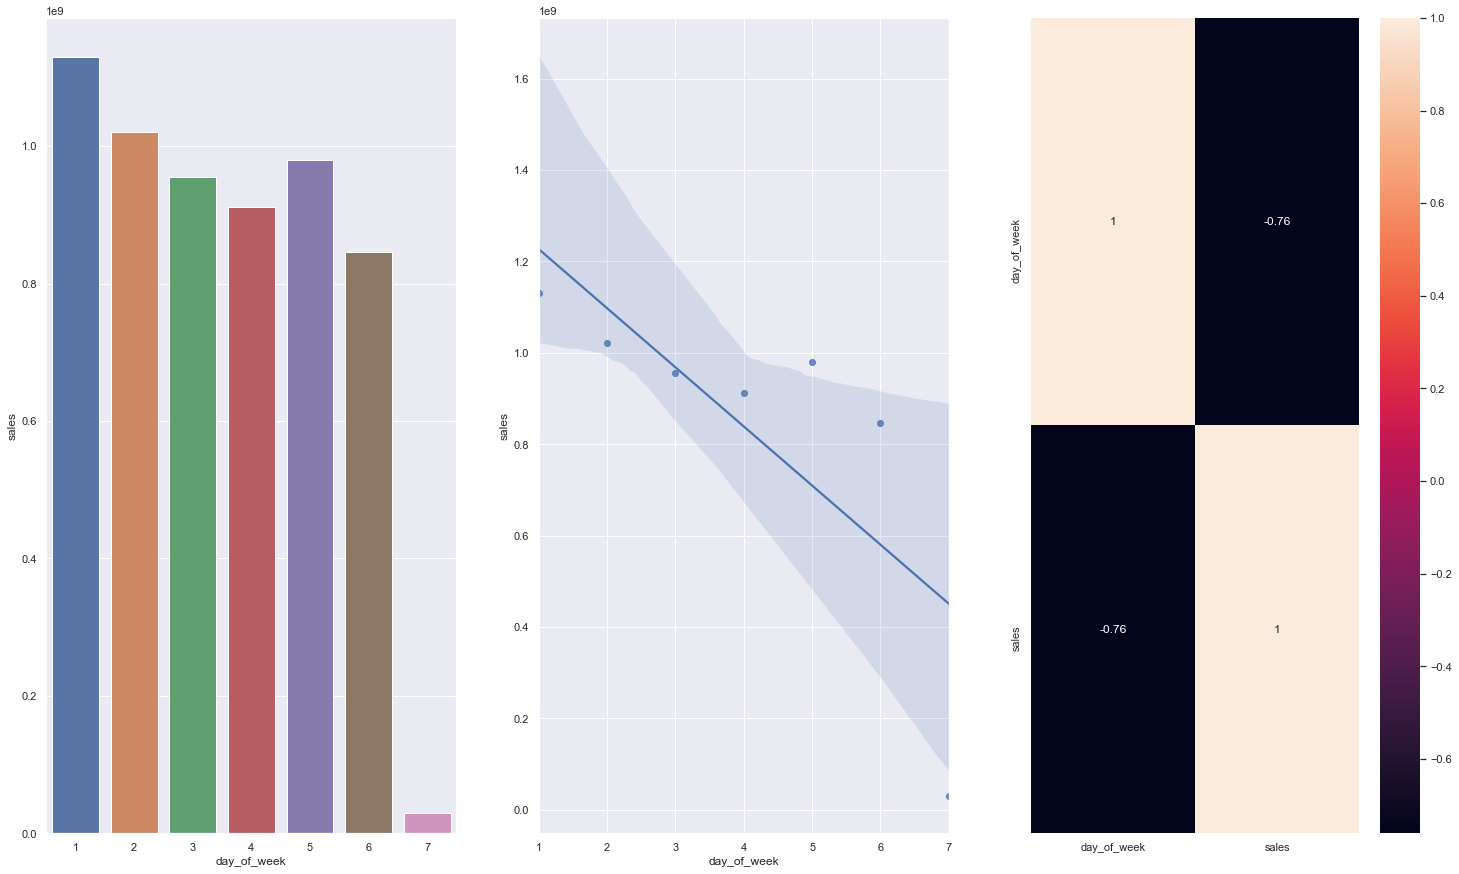

In [50]:
plt.figure(figsize=(25,15))

aux1 = df4[ [ 'day_of_week', 'sales' ] ].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True );

A hipótese é verdadeira, pois como vimos, as vendas são muito maiores nos dias de semana.

### H12 - Lojas deveriam vender menos durante os feriados escolares. (**V**)

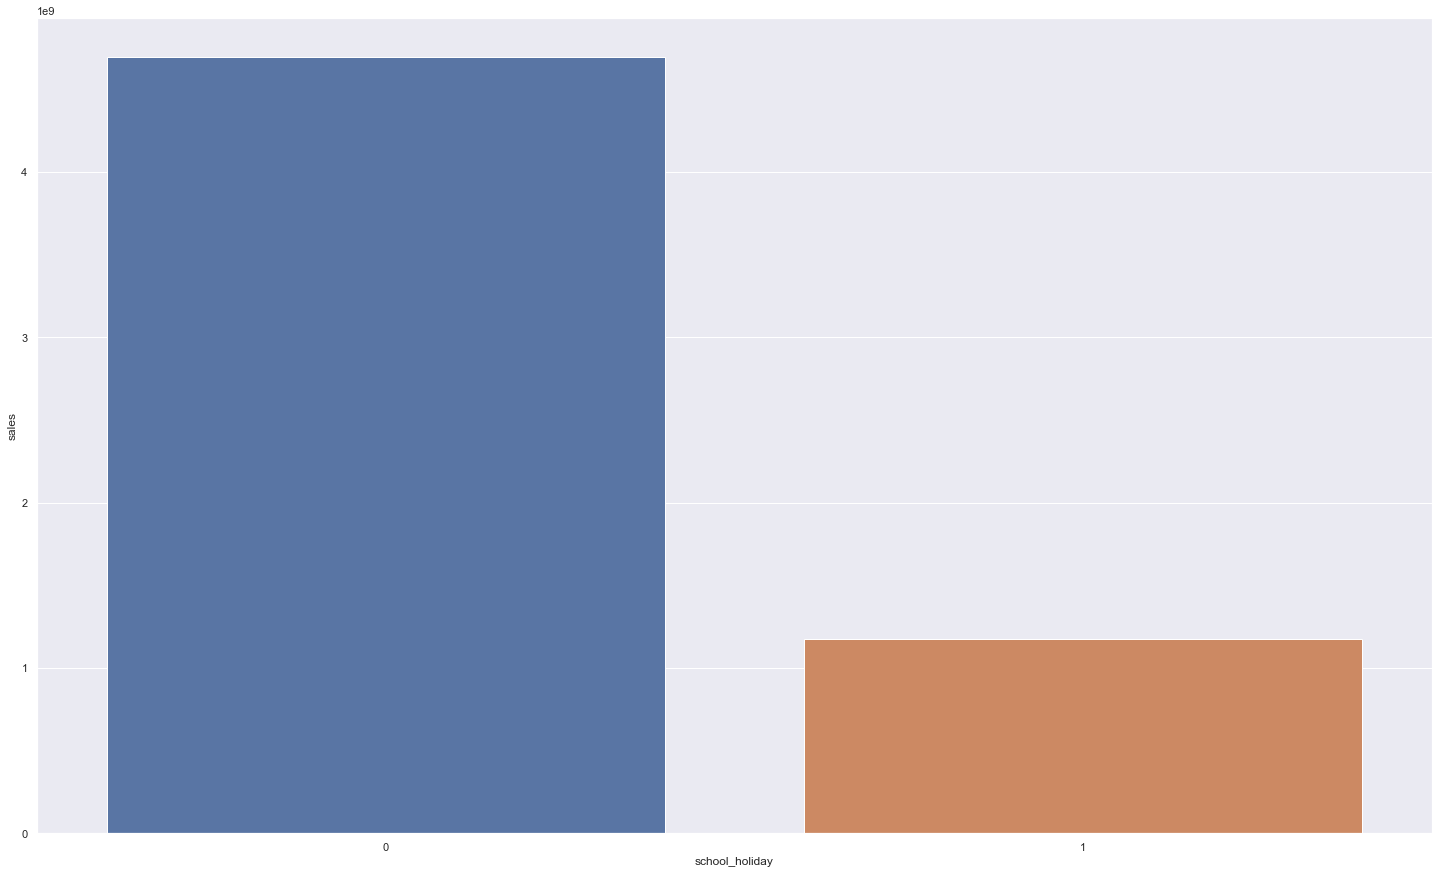

In [51]:
plt.figure(figsize=(25,15))

aux1 = df4[ [ 'school_holiday', 'sales' ] ].groupby('school_holiday').sum().reset_index()

sns.barplot( x='school_holiday', y='sales', data=aux1 );

As lojas realmente vendem menos nos feriados escolares, mas vamos desmembrar em mes a mes pra ver se tem algum mes em que feriados escolares vendem mais.

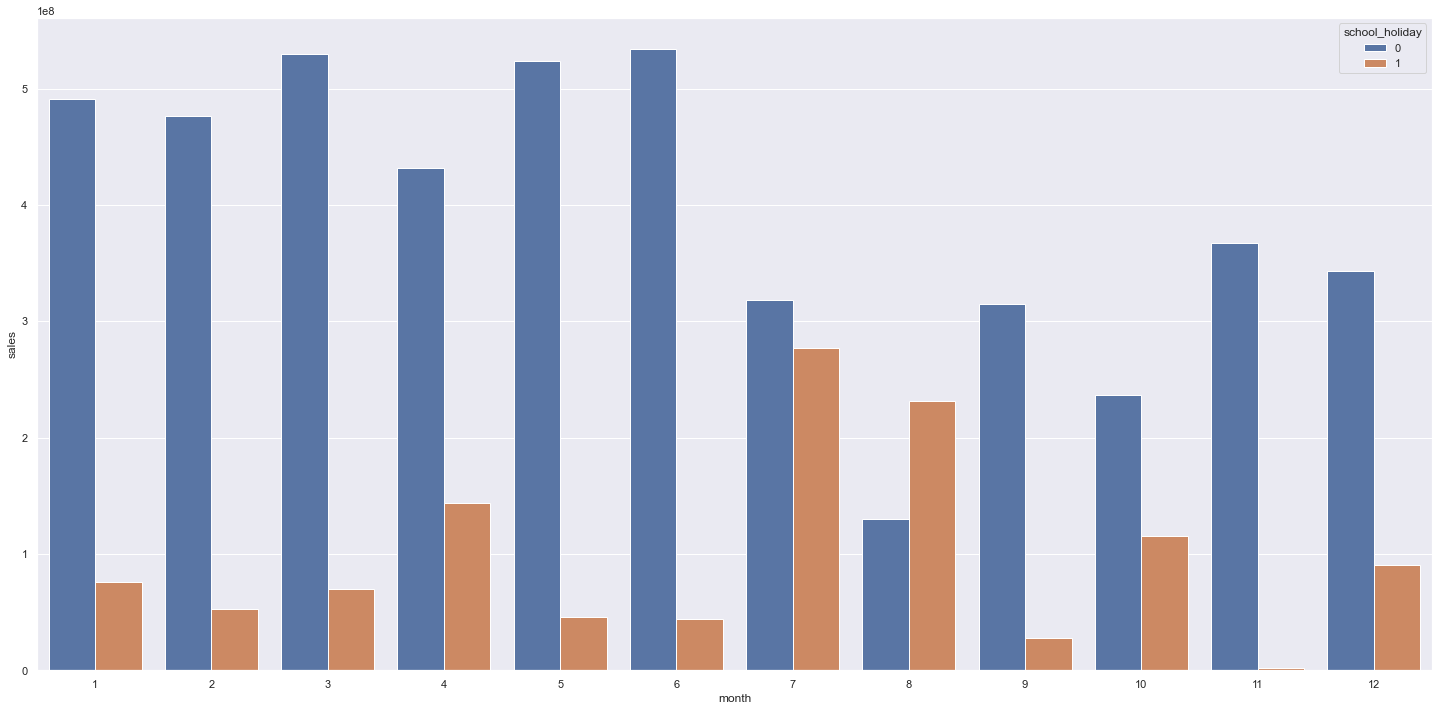

In [52]:
aux2 = df4[ [ 'month', 'school_holiday', 'sales' ] ].groupby(['school_holiday', 'month']).sum().reset_index()

sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

Nos meses de Julho e Agosto as vendas nos feriados escolares aumentam, isso provavelmente devido às férias escolares. (início do ano letivo).

### 4.2.1 - Resumo das hipóteses

In [53]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 - Análise multivariada

A análise multivariada serve para mostrar visualmente, as variáveis correlacionadas, para que assim possa se identificar as melhores variáveis para ir ao modelo, dessa forma diminui-se a dimensionalidade e a complexidade do modelo.

### 4.3.1 - Atributos numéricos

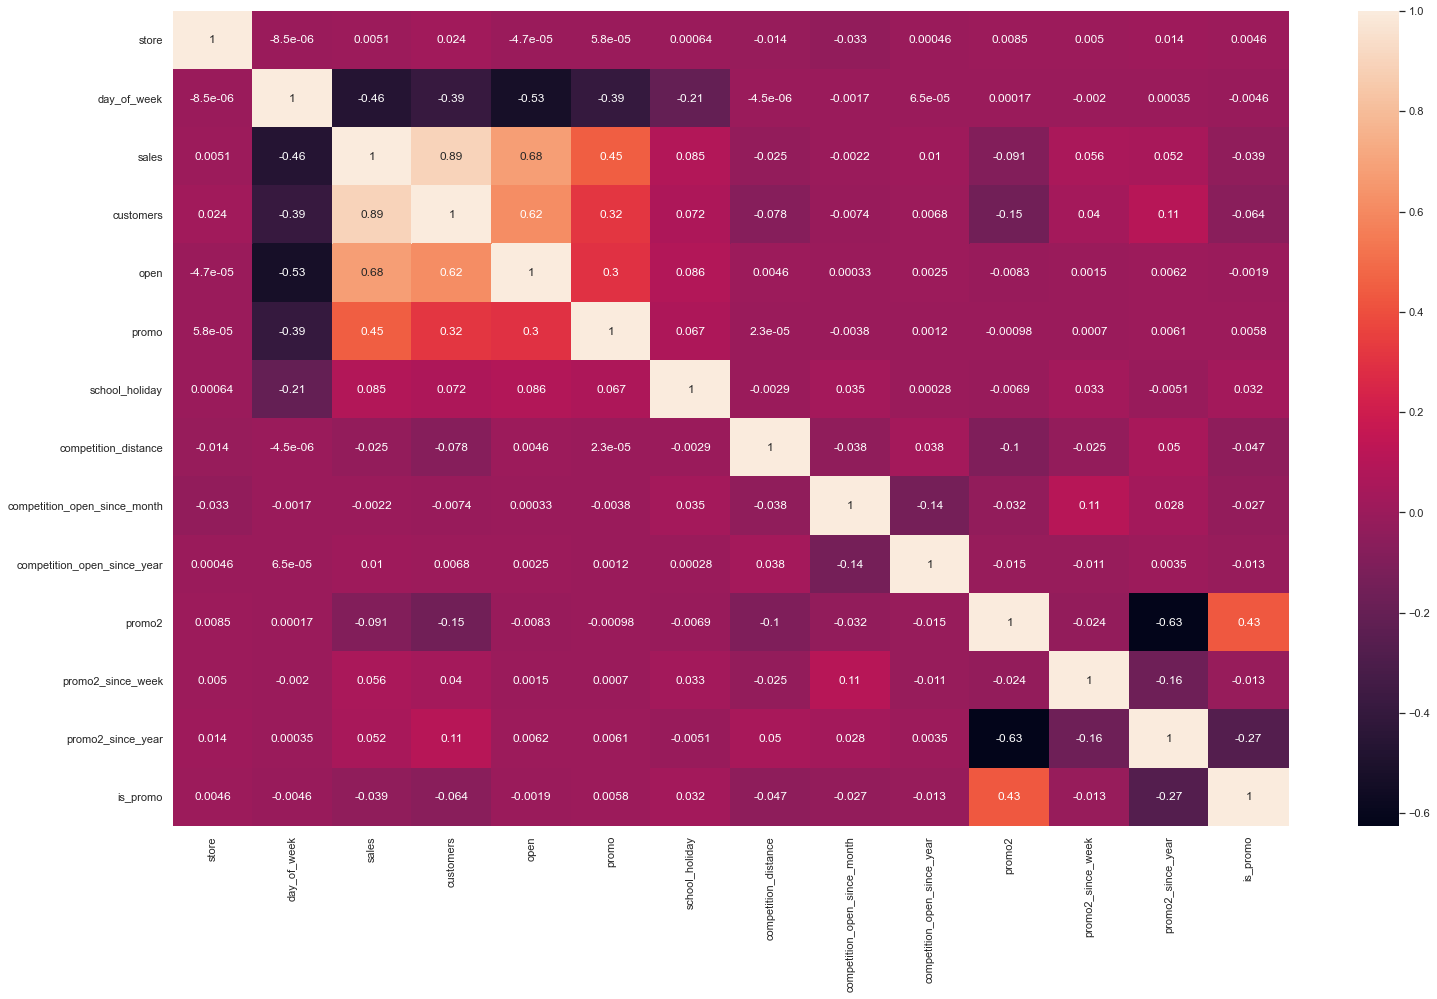

In [54]:
plt.figure(figsize=(25,15))

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2 - Atributos categóricos

Usaremos o método de V de cramér para fazermos a análise. Na estatística, o V de Cramér é uma medida de associação entre duas variáveis categóricas, fornecendo um valor entre 0 e +1.

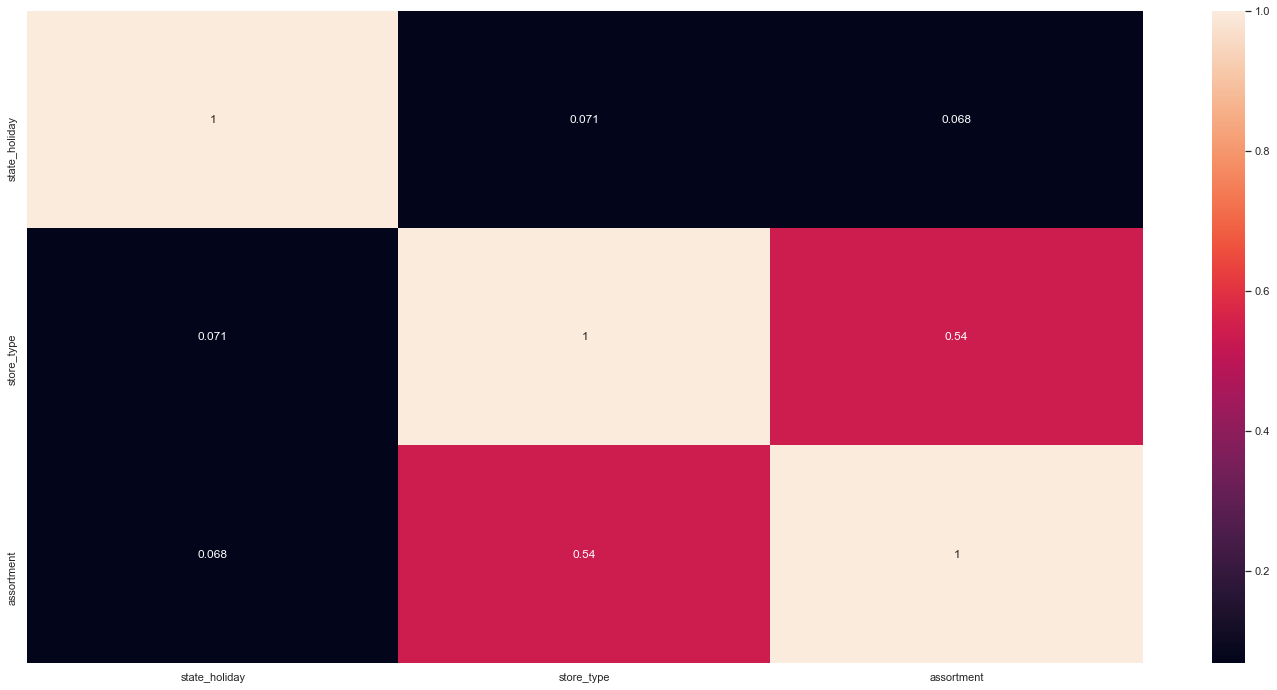

In [55]:
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# 5.0 - PREPARAÇÃO DE DADOS

<center><img width="60%" src="https://image.freepik.com/vetores-gratis/os-especialistas-em-inteligencia-de-negocios-transformam-dados-em-informacoes-uteis-inteligencia-de-negocios-analise-de-negocios-conceito-de-ferramentas-de-gerenciamento-de-ti_335657-1889.jpg
"></center>

Agora há a necessidade da preparação de dados para criarmos o modelo de machine learning. O aprendizado da maioria dos algoritmos de *Machine Learning* é facilitado com dados **NUMÉRICOS** e na mesma **ESCALA**. portando nessa fase do projeto o objetivo é transformar as variáveis categóricas em numéricas e deixar os dados na mesma escala.
Existem 3 tipo de preparação de dados:
* **Normalização:** Rescala o centro para 0 com desvio padrão igual a 1 (funciona para variáveis com distribuição normal)
* **Rescaling:** Rescala para o intervalo entre 0 e 1. (funciona melhor para variáveis sem distribuição gaussiana)
* **Tranformação:** Conversão de Features Categóricas para Numéricas (encoding)

In [56]:
df5 = df4.copy()

## 5.1 - Normalização

Como visto na seção 4.1.2, as distribuições das variaveis não são do tipo normal, portanto não precisamos aplicar a normalização.

## 5.2 - Rescaling

In [57]:
rs = RobustScaler()
mms = MinMaxScaler()

gráficos boxplot para verificar se possui outlier significativo.

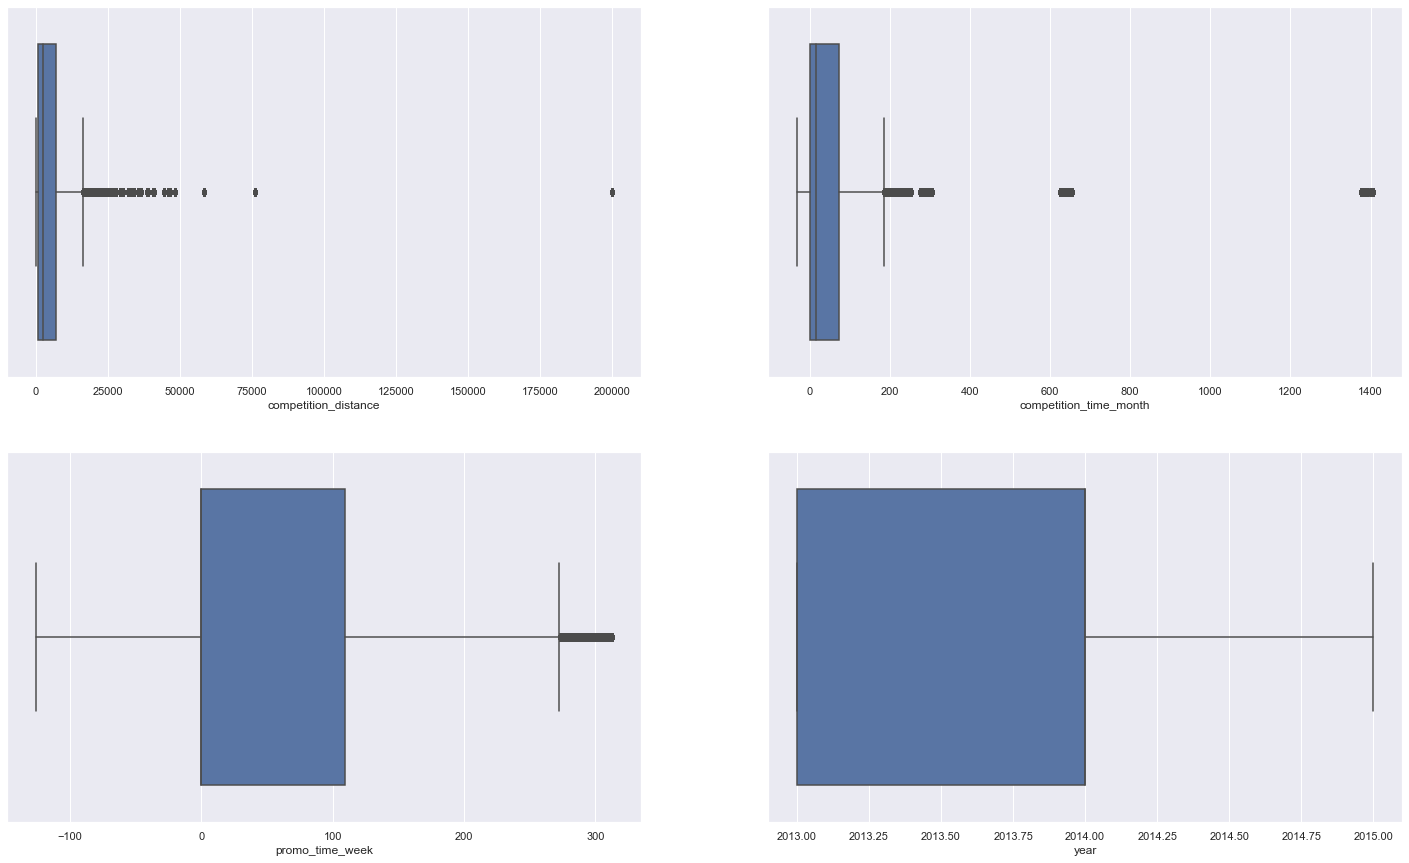

In [58]:
plt.figure(figsize=(25,15))

plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance']);

plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month']);

plt.subplot(2,2,3)
sns.boxplot(df5['promo_time_week']);

plt.subplot(2,2,4)
sns.boxplot(df5['year']);

As variáveis *competition_distance* e *competition_time_month* possuem outlier significativo e por esse motivo, vou usar o RobustScaler para rescalar os dados, para os demais usarei o MinMaxScaler.

In [150]:
# competition_distance
df5['competition_distance'] =  rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] =  rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] =  mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] =  mms.fit_transform( df5[['year']].values )

## 5.3 - Transformação

### 5.3.1 - Encoding

In [60]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [151]:
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le .fit_transform(df5['store_type'])
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

In [62]:
# assortment - Ordinal Encoding
assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 - Transformação da variável resposta

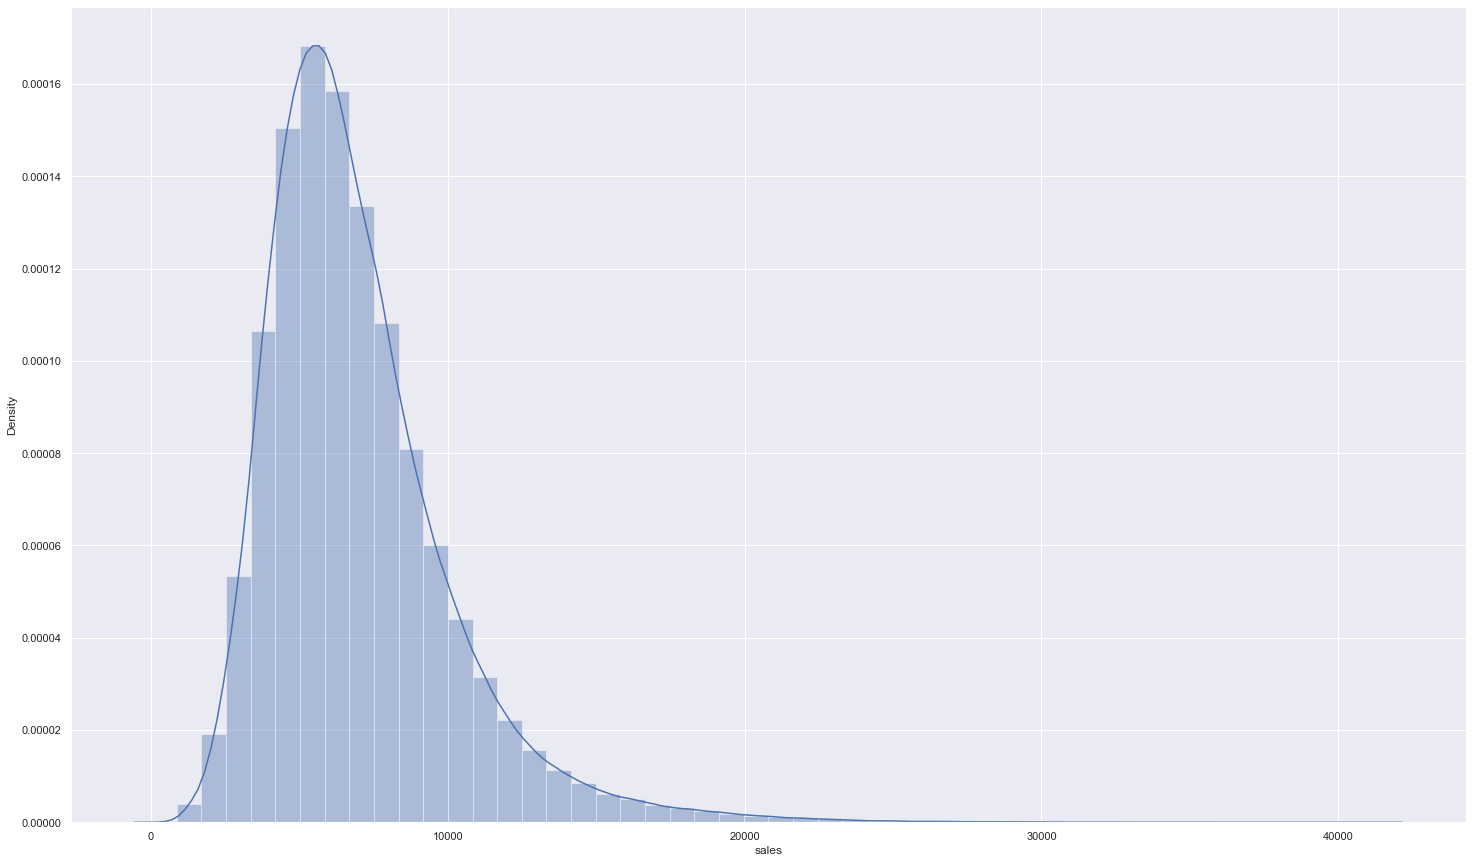

In [63]:
plt.figure(figsize=(25,15))
sns.distplot( df5['sales'] );

Vamos usar a transformação logarítmica para melhorarmos para o modelo:

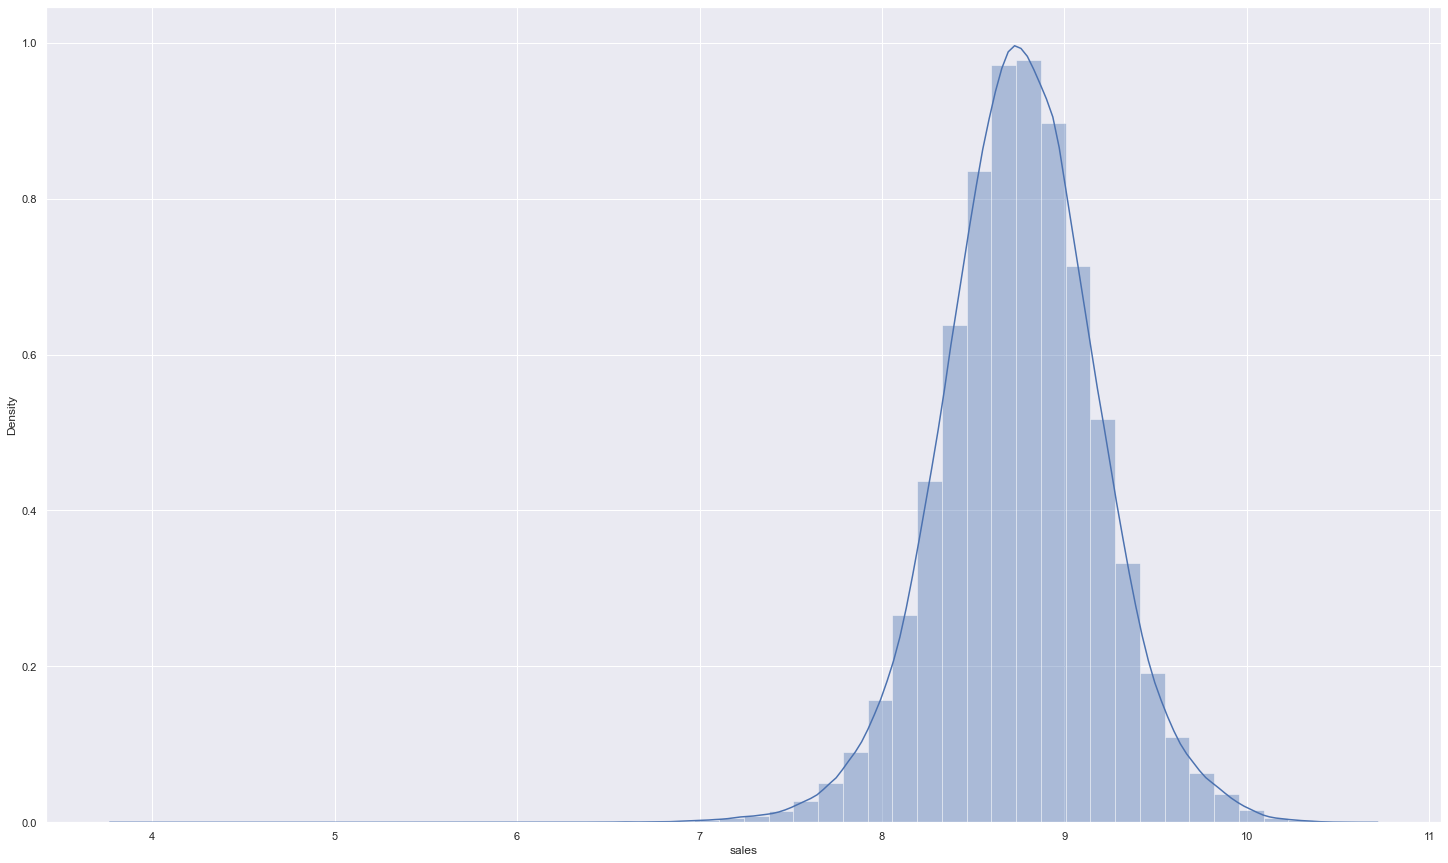

In [64]:
plt.figure(figsize=(25,15))
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot( df5['sales'] );

### 5.3.3 - Transformação de natureza

Para esse projeto, temos que levar em consideração que algumas variáveis são cíclicas, por exemplo um ano possui 12 meses, e dezembro de uma ano está proximo do janeiro do ano posterior. Para levar em consideração essa ciclicidade irei transformar as variáveis.

In [65]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2 * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2 * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2 * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2 * np.pi/52 ) ) )

# 6.0 - FEATURE SELECTION

<center><img width="40%" src="https://image.freepik.com/vetores-gratis/selecione-a-ilustracao-do-conceito_114360-383.jpg
"></center>

Vamos selecionar as variáveis mais **relevantes** para o aprendizado do modelo. Existem 3 métodos de seleção de variáveis:
* 1) Seleção Univariada: Seleciona as variáveis por correlação.
* 2) Seleção por importancia: Seleciona as variáveis por importância.
* 3) Seleção por subset: Seleciona as variáveis através de métodos e cálculos estatísticos.

Nesse projeto vou usar a seleção por subset, através de um algorítmo chamado *BORUTA*

In [66]:
df6 = df5.copy()

## 6.1 - Separar o dataset em treino e teste

Primeiramente vamos excluir algumas colunas "originais" que já foram derivadas.

In [67]:
cols_drop = [ 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

Agora vamos separar os dados em treino e teste, por ser uma *time series* não vou separar aleatoriamente, pois poderia prejudicar no resultado do modelo de *Machine Learning*, em vez disso vou pegar todos os valores que estão na data 6 semanas antes do ultimo registro de vendas e colocar no treino, e o restante no teste.

In [68]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [69]:
# Dados de treino
X_train = df6[ df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# Dados de teste
X_test = df6[ df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print( 'Training min date: {}'.format( X_train['date'].min() ) )
print( 'Training max date: {}'.format( X_train['date'].max() ) )

print( '\nTest min date: {}'.format( X_test['date'].min() ) )
print( 'Test max date: {}'.format( X_test['date'].max() ) )

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 - Usando o Boruta para Feature Selection.

In [70]:
# Training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define Random Forest
rf = RandomForestRegressor(n_jobs=-1)

# Define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

KeyboardInterrupt: 

### 6.2.1 - Best Features for Boruta

Agora que rodamos o boruta, vamos verificar as variáveis selecionadas pelo boruta, e as que não foram também

In [ ]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Not Selected Boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta

## 6.3 - Manual Feature Selection

Vamos criar uma lista com as variáveis selecionados pelo boruta e acrescentar mais algumas variáveis que julguei necessário:

In [71]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [72]:
# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 - MACHINE LEARNING MODELLING

<center><img width="40%" src="https://image.freepik.com/vetores-gratis/cerebro-com-circuito-digital-e-programador-com-laptop-aprendizado-de-maquina-inteligencia-artificial-cerebro-digital-e-conceito-de-processo-de-pensamento-artificial-ilustracao-isolada-em-vetor_335657-2246.jpg
"></center>

O algorítmo de machine learning serve para aprender o comportamento de um fenômeno com as variáveis disponíveis e então generaliza-lo para o futuro

In [81]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Data for Cross Validation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 - Average model

Usarei o "modelo" de média para ter uma baseline de comparação com outros modelos mais robustos.

In [74]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[ ['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions'] 

# Performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 - Linear Regression Model

In [75]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


Pode-se observar que o modelo de regressão está muito pior que o modelo de média, o que leva a crer que ele não é linear, vamos usar o cross validation para verificar se melhora o desempenho:

### 7.2.1 - Linear Regression Model- Cross Validation

In [84]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 - Linear Regression  Regularized Model - LASSO

In [76]:
# Model
lrr = Lasso(alpha=0.01).fit( x_train, y_train )

# Prediction
yhat_lrr = lrr.predict( x_test )

# Performance
lrr_result = ml_error( 'Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 - Lasso- Cross Validation

In [85]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


Realmente, os modelos lineares não poderão ser utilizados para esse projeto, a partir de agora usarei os modelos não lineares para fazer as previsões.

## 7.4 - Random Forest

In [77]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict( x_test )

# Performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.09996,1011.191561


### 7.4.1 - Random Forest - Cross Validation

In [86]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36


## 7.5 - XGBoost Regressor

In [78]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[12:32:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6064,0.949503,7330.742181


### 7.5.1 - XGBoost Regressor - Cross Validation

In [88]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
xgb_result_cv

[13:09:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:10:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:11:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

,Model Name,MAE CV,MAPE CV,RMSE
0,XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


## 7.6 - Comparing models performance

### 7.6.1 - Single Performance

In [79]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.099960,1011.191561
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.606400,0.949503,7330.742181


### 7.6.2 - Real Performance - Cross Validation

In [90]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36
0,XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


# 8.0 - HYPERPARAMETER AND FINE TUNNING

<center><img width="40%" src="https://image.freepik.com/vetores-gratis/poster-informativo-fine-tuning-mechanism-flat_81522-3857.jpg
"></center>

O objetivo é encontrar o conjunto de parâmetros para maximizar o aprendizado do modelo.
Existem 3 estratégias para encontrar esses conjuntos:
* Random Search
* Grid Search
* Bayesian Search

Usaremos a *Random Search* pois é a mais rápida de todas e entrega um resultado satisfatório.

## 8.1 - Random Search

Usarei o XGBoost para fazer o Fine tunning.

In [96]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [97]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold nunmber: 5
[16:48:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold nunmber: 4
[16:52:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold nunmber: 3
[16:55:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_

[19:20:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold nunmber: 4
[19:37:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold nunmber: 3
[19:54:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XG

,Model Name,MAE CV,MAPE CV,RMSE
0,XGBoost Regressor,1321.75 +/- 137.39,0.18 +/- 0.01,1899.98 +/- 169.11
0,XGBoost Regressor,955.14 +/- 143.35,0.13 +/- 0.01,1375.92 +/- 198.41
0,XGBoost Regressor,1788.66 +/- 186.0,0.25 +/- 0.01,2562.75 +/- 255.22
0,XGBoost Regressor,1279.97 +/- 142.57,0.18 +/- 0.01,1858.09 +/- 176.77
0,XGBoost Regressor,810.54 +/- 115.95,0.11 +/- 0.01,1166.68 +/- 170.86


 Pelo Fine tuning, chegamos nos seguintes hiperparametros 'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3.
 E com esses valores vamos colocar no modelo final e verificar se podemos mandar em produção.

## 8.2 - Final Model

In [101]:
param_tuned = {'n_estimators': 3500 ,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.1,
               'colsample_bytree': 0.9, 
               'min_child_weight': 3 
               }

In [102]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

[21:25:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,634.416794,0.09223,928.561866


In [116]:
mpe = mean_percentage_error( expm1(y_test), expm1(yhat_xgb_tuned) )
mpe

0.003312640083229963

# 9.0 - ERROR INTERPRETATION

<center><img width="40%" src="https://image.freepik.com/vetores-gratis/treinador-falando-antes-da-audiencia-mentor-apresentando-graficos-e-relatorios-funcionarios-reunidos-em-treinamento-empresarial-seminario-ou-conferencia-ilustracao-vetorial-para-apresentacao-palestra-educacao_74855-8294.jpg
"></center>

Agora irei interpretar o signicado dos erros, para que quem ler o projeto possa entender o que esses números signicam, e dessa forma poderem tomar a melhor decisão para os investimentos nas lojas.

In [120]:
df9 = X_test[ cols_selected_boruta_full ]

# Rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 - Business Performance

In [130]:
# Sum of predictions
df91 = df9[ ['store', 'predictions'] ].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[ ['store', 'sales', 'predictions'] ].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAE'} )
df9_aux2 = df9[ ['store', 'sales', 'predictions'] ].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAPE'} )
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )

df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Ordering the columns
df92 = df92[ ['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE'] ]

Criei uma tabela com os valores das predições de vendas e seus erros, juntei além disso os melhores e os piores cenários para as vendas de acordo com o modelo

In [132]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1020,1021,333535.87500,332828.043325,334243.706675,707.831675,0.072342
41,42,369717.21875,368688.603384,370745.834116,1028.615366,0.099274
341,342,398460.53125,397338.964355,399582.098145,1121.566895,0.092971
942,943,262897.56250,262400.518647,263394.606353,497.043853,0.071573


In [135]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105382.171875,102048.801873,108715.541877,3333.370002,0.560489
908,909,236016.437500,228330.636273,243702.238727,7685.801227,0.521190
594,595,349152.000000,344285.486816,354018.513184,4866.513184,0.337943
875,876,201029.515625,197084.915580,204974.115670,3944.600045,0.297248
721,722,347369.875000,345530.040527,349209.709473,1839.834473,0.248508


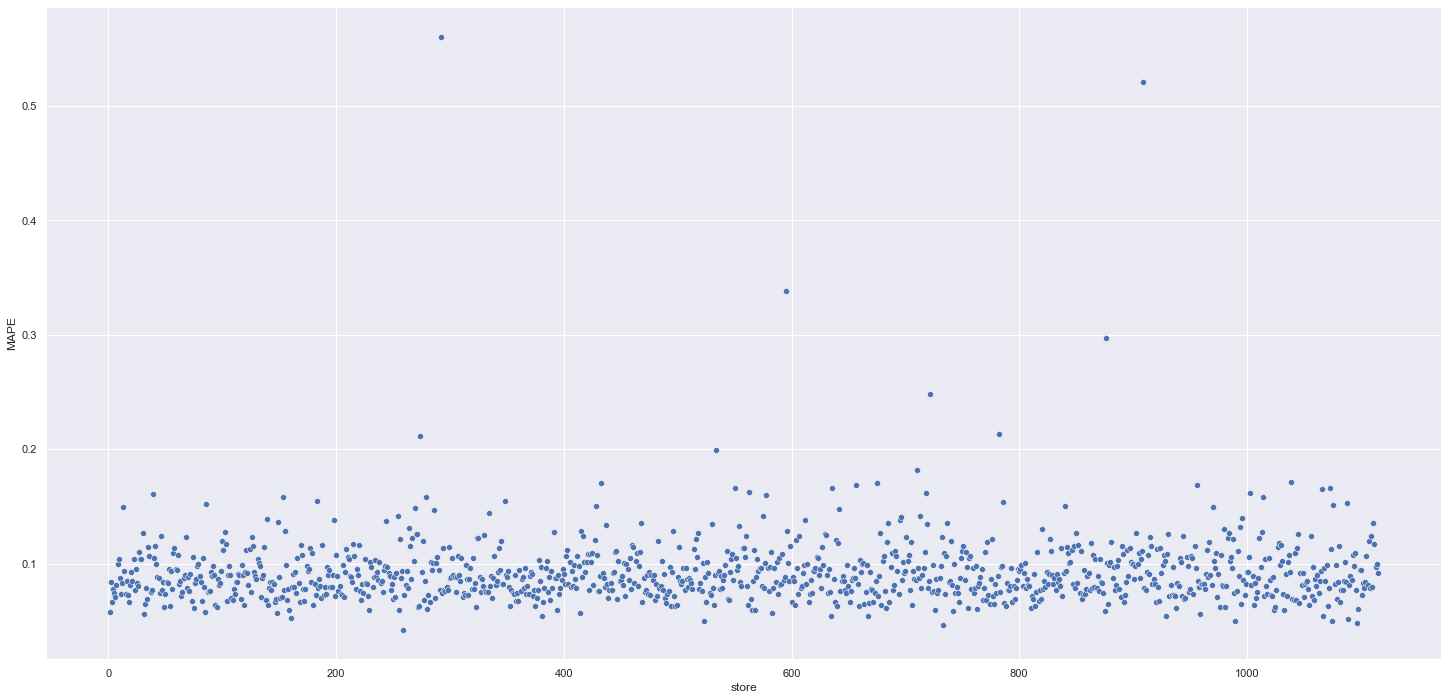

In [136]:
sns.scatterplot( x='store', y='MAPE', data=df92);

No geral o erro fica abaixo de 10%, o que é um ótimo valor, porém existem algumas lojas em que a previsão não está muito boa, ultrapassando os 50% de erro. Cabe agora ao time de gestão decidir o melhor caminho, mas poderei posteriormente analisar cada uma dessas lojas em que o modelo não funcionou de forma satisfatória.

## 9.2 - Total Performance

Vou somar as previsões de venda de todas as lojas, bem como o pior e o melhor cenário. 

In [142]:
df93 = df92[ ['predictions', 'worst_scenario', 'best_scenario'] ].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )

In [143]:
df93

,Scenario,Values
0,predictions,"R$ 284,074,496.00"
1,worst_scenario,"R$ 283,363,122.74"
2,best_scenario,"R$ 284,785,887.23"


## 9.3 - Machine Learning Performance

In [144]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

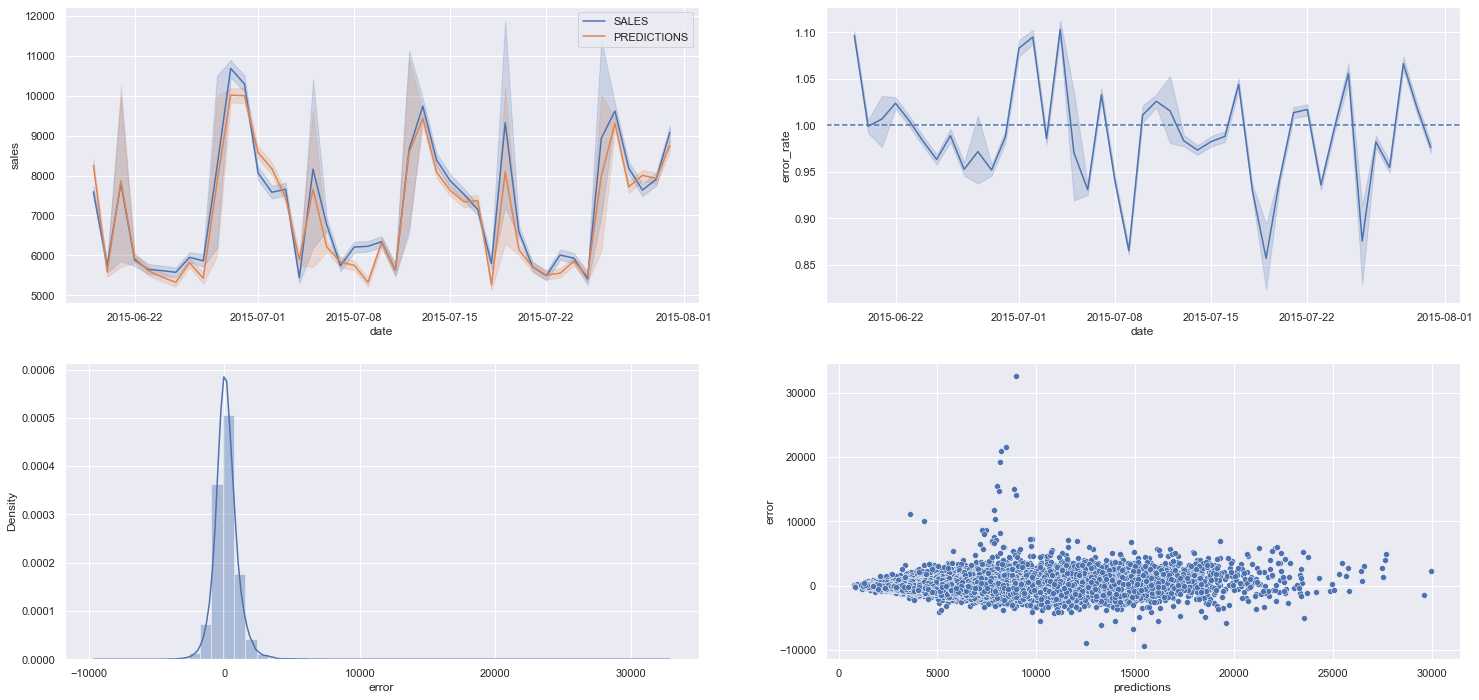

In [148]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 );
plt.axhline( 1, linestyle='--');

plt.subplot( 2, 2, 3 )
sns.distplot(df9['error']);

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'] );

- Do primeiro gráfico podemos ver que as predições ao longo do tempo se comportam como as vendas reais;
- No segundo gráfico podemos observar a super ou sub estimação ao longo do tempo;
- No terceiro gráfico mostra a distribuição do erro, e ela está próximo de uma distribuição normal, o que é bom;
- No quarto gráfico podemos ver que os erros eles estão dentro de um range, (com alguns outliers) mas no geral o modelo está muito bom.